<a href="https://colab.research.google.com/github/trngbich/MetaanalysisBiasET/blob/main/PBias_meta_analyses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install joypy

In [3]:
!pip install scikit-posthocs

In [4]:
!pip install pymannkendall

In [5]:
# Import  libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import string
import joypy
import altair as alt
import seaborn as sns
from plotly import figure_factory as ff
from scipy import stats
from scipy.stats import linregress
from scipy.stats import ttest_ind, ttest_1samp, f_oneway,kruskal
from scipy.stats import mannwhitneyu
import scikit_posthocs as sp
import pymannkendall as mk
from itertools import combinations
plt.style.use('seaborn-v0_8-whitegrid')


# Read data

**Note**: Make sure Filter is off

In [6]:
# File path
file_path = "/content/drive/MyDrive/Co-research/P2_meta-analysis/RSETValidationPapers_with_PBias.xlsm"
save_folder = "/content/drive/MyDrive/Co-research/P2_meta-analysis/"
# Read Excel file
df = pd.read_excel(file_path, skiprows=2)

# Filter only rows with numerical values in the "PBIAS" column
df_numeric_pBIAS = df[pd.to_numeric(df['PBIAS (%)'], errors='coerce').notnull()]

In [7]:
df.columns

Index(['Row_ID', 'record_id', 'recorded_by', 'title', 'authors', 'year',
       'abstract', 'journal', 'doi',
       'Kawa to update IGBP, DEM and Climate class', 'BIAS (mm/dt)',
       'Observed ET (mm/dt)', 'BIAS (MJ/m2/day)', 'BIAS (W/m2)',
       'Observed ET (W/m2)', 'PBIAS (%)', 'dt', 'Temporal support (dt)',
       'Spatial support (m x m)', 'Start date', 'End date',
       'number of observations', 'Growing season? (y/n)',
       'Number of sites (N)', 'Site name in study', 'Conventional site name',
       'IGBP class from text', 'Latitude (degree North)',
       'Longitude (degree East)', 'Country_code', 'Altitude (m a.s.l)',
       'Crop type', 'Climate class', 'Height of sensor (m)', 'Y_DM', 'X_DM',
       'IGBPQGIS from MODIS', 'IGBP_HYBMAP2000', 'SRTM_DEM GEE',
       'SRTM_DEM 30m', 'KOPPEN _ Beck et al. (2023) QGIS',
       'KOPPEN _ Beck et al. (2023)', 'IGBP', 'Elevation (m)',
       'Koppen-Geiger 1st', 'Koppen-Geiger 2nd', 'Koppen-Geiger 3rd',
       'EB correction',

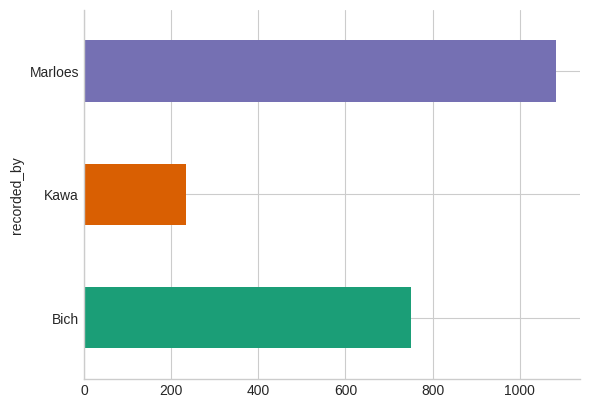

In [8]:
df.groupby('recorded_by').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

# Dataset description

Question: How PBIAS values are distributed? What is the range of PBIAS?

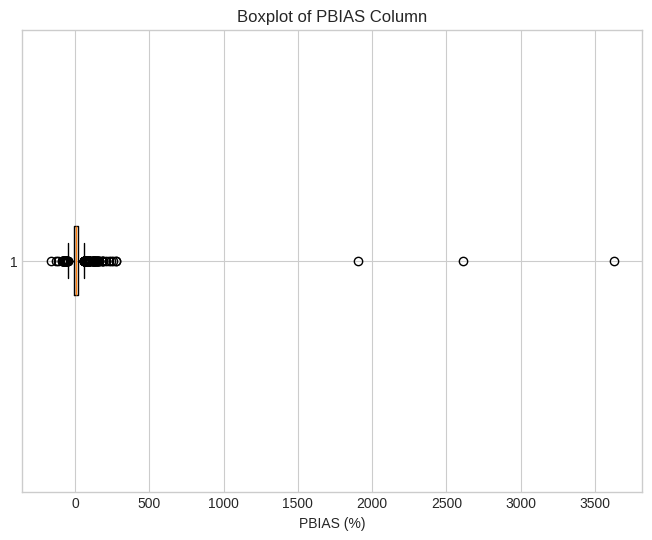

In [9]:
# Plot boxplot of the 'PBIAS' column
plt.figure(figsize=(8, 6))
plt.boxplot(df_numeric_pBIAS['PBIAS (%)'], vert=False)
plt.xlabel('PBIAS (%)')
plt.title('Boxplot of PBIAS Column')
plt.show()

The distribution shows some data point with PBIAS > 1000%. These are outliers due to very small ET values

## Remove outliers

Number of data points: 2063
Number of outliers beyond ±2 standard deviations: 7


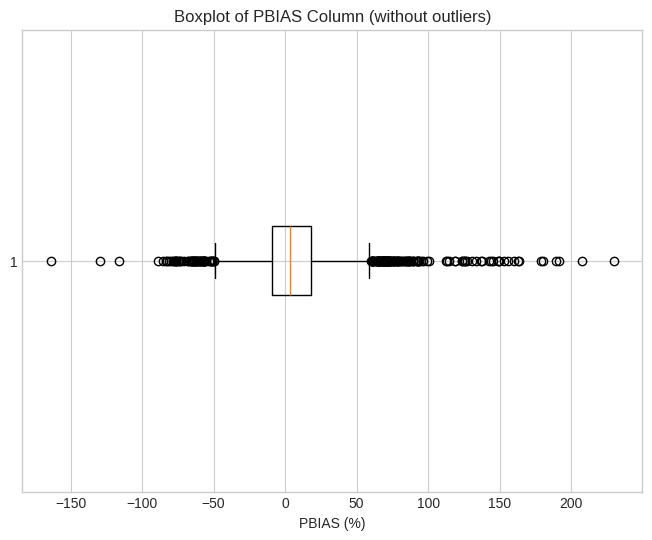

In [10]:
# Define a threshold for outliers (e.g., values beyond ±threshold standard deviations)
threshold = 2

# Calculate the mean and standard deviation of the 'PBIAS' column
mean_pBIAS = df_numeric_pBIAS['PBIAS (%)'].mean()
std_pBIAS = df_numeric_pBIAS['PBIAS (%)'].std()

# Define bounds
lower_bound = mean_pBIAS - threshold * std_pBIAS
upper_bound = mean_pBIAS + threshold * std_pBIAS

# Filtered data (without outliers)
filtered_df = df_numeric_pBIAS[(df_numeric_pBIAS['PBIAS (%)'] >= lower_bound) &
                               (df_numeric_pBIAS['PBIAS (%)'] <= upper_bound)]


# Identify outliers
outliers = df_numeric_pBIAS[(df_numeric_pBIAS['PBIAS (%)'] < lower_bound) |
                            (df_numeric_pBIAS['PBIAS (%)'] > upper_bound)]

# Count outliers
n_total = len(filtered_df)
print(f"Number of data points: {n_total}")

# Number of data
n_outliers = len(outliers)
print(f"Number of outliers beyond ±{threshold} standard deviations: {n_outliers}")

# Plot boxplot of the filtered 'PBIAS' column
plt.figure(figsize=(8, 6))
plt.boxplot(filtered_df['PBIAS (%)'], vert=False)
plt.xlabel('PBIAS (%)')
plt.title('Boxplot of PBIAS Column (without outliers)')
plt.show()

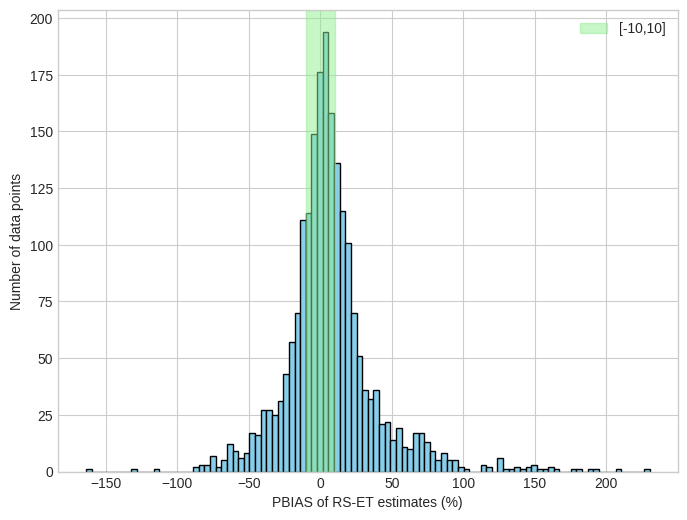

In [11]:
plt.figure(figsize=(8, 6))
plt.hist(filtered_df['PBIAS (%)'], bins=100, color='skyblue', edgecolor='black')
plt.xlabel('PBIAS of RS-ET estimates (%)')
plt.ylabel('Number of data points')
# plt.title('Histogram of PBIAS Column')
plt.grid(True)
# Add vertical lines at -10% and 10%
plt.axvspan(-10, 10, color='lightgreen', alpha=0.5,label='[-10,10]')
plt.legend()
plt.show()

In [12]:
# Test for normality using the Shapiro-Wilk test
# Null hypothesis: the data is normally distributed
# Alternative hypothesis: the data is not normally distributed
shapiro_test = stats.shapiro(filtered_df['PBIAS (%)'])

print(f"Shapiro-Wilk Test statistic: {shapiro_test.statistic}")
print(f"Shapiro-Wilk Test p-value: {shapiro_test.pvalue}")

# Interpret the result
alpha = 0.05  # significance level
if shapiro_test.pvalue > alpha:
    print("The data appears to be normally distributed (fail to reject H0)")
else:
    print("The data does not appear to be normally distributed (reject H0)")

Shapiro-Wilk Test statistic: 0.89683709003656
Shapiro-Wilk Test p-value: 3.841393302806155e-35
The data does not appear to be normally distributed (reject H0)


Shapiro-Wilk Test statistic: 0.89683709003656

Shapiro-Wilk Test p-value: 3.841393302806155e-35

The data does not appear to be normally distributed (reject H0)

The Shapiro-Wilk test is used to check if a sample comes from a normally distributed population.
The null hypothesis (H0) is that the data is normally distributed.
The alternative hypothesis (H1) is that the data is not normally distributed.
We use a significance level (alpha) of 0.05.
If the p-value is greater than alpha, we fail to reject the null hypothesis, suggesting the data is likely normally distributed.
If the p-value is less than or equal to alpha, we reject the null hypothesis, suggesting the data is likely not normally distributed.
The results above show the test statistic and p-value for the 'PBIAS (%)' column within each group.
Based on the p-value for each group compared to alpha, we can determine whether the 'PBIAS (%)' data within that specific group follows a normal distribution.

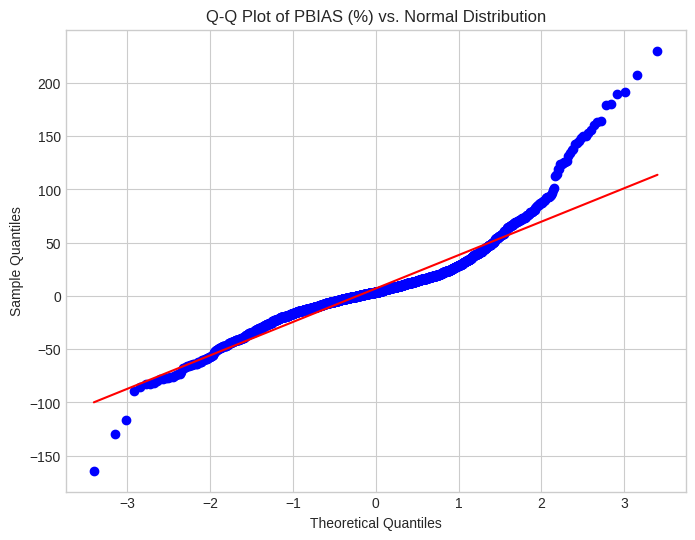

In [13]:
plt.figure(figsize=(8, 6))
stats.probplot(filtered_df['PBIAS (%)'], dist="norm", plot=plt)
plt.title('Q-Q Plot of PBIAS (%) vs. Normal Distribution')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.grid(True)
plt.show()

In [14]:
hist_data = [filtered_df['PBIAS (%)'].astype(float)]
group_labels = ['PBIAS (%)'] # name of the dataset

fig = ff.create_distplot(hist_data, group_labels)
fig.show()

## Plot probrability distribution and statistics

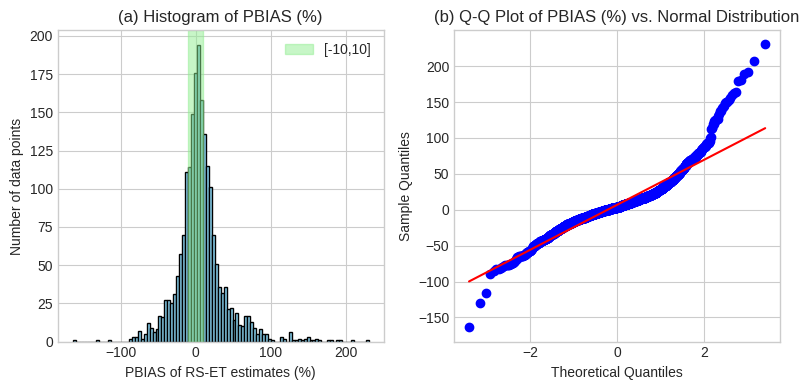

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Subplot (a): Histogram
axes[0].hist(filtered_df['PBIAS (%)'], bins=100, color='skyblue', edgecolor='black')
axes[0].set_xlabel('PBIAS of RS-ET estimates (%)')
axes[0].set_ylabel('Number of data points')
axes[0].grid(True)
axes[0].axvspan(-10, 10, color='lightgreen', alpha=0.5, label='[-10,10]')
axes[0].legend()
axes[0].set_title('(a) Histogram of PBIAS (%)')

# Subplot (b): Q-Q plot
stats.probplot(filtered_df['PBIAS (%)'], dist="norm", plot=axes[1])
axes[1].set_title('(b) Q-Q Plot of PBIAS (%) vs. Normal Distribution')
axes[1].set_xlabel('Theoretical Quantiles')
axes[1].set_ylabel('Sample Quantiles')
axes[1].grid(True)

plt.tight_layout()
plt.savefig(os.path.join(save_folder,'1_pbias_distribution.png'), bbox_inches='tight')
plt.show()



- Percentage of validation points result in high accuracy (PBIAS <10%)
-




In [16]:
# Calculate the number of data points with PBIAS < 10%
n_high_accuracy = len(filtered_df[filtered_df['PBIAS (%)'].abs() < 10])

# Calculate the percentage
percentage_high_accuracy = (n_high_accuracy / n_total) * 100

print(f"Percentage of records with PBIAS < 10%: {percentage_high_accuracy:.2f}%")

Percentage of records with PBIAS < 10%: 38.29%


In [17]:
# Calculate descriptive statistics
pbias_stats = filtered_df['PBIAS (%)'].describe()

# Print the descriptive statistics
print(pbias_stats)

count    2063.000000
mean        6.872709
std        33.146884
min      -164.000000
25%        -9.106773
50%         3.460000
75%        18.000000
max       230.279898
Name: PBIAS (%), dtype: float64


## PBIAS distribution with ET

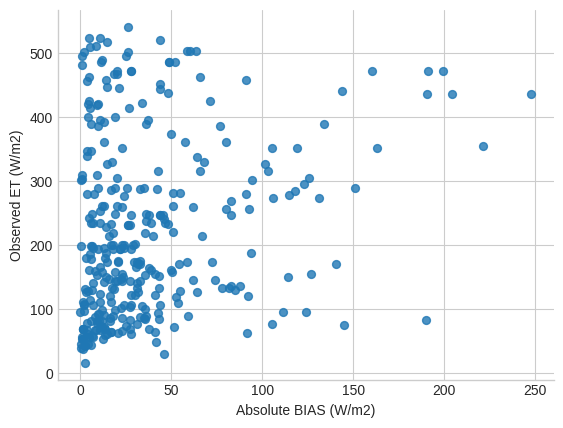

In [18]:
plt.scatter(filtered_df['BIAS (W/m2)'].abs(), filtered_df['Observed ET (W/m2)'], s=32, alpha=.8)
plt.xlabel('Absolute BIAS (W/m2)') # Update the x-axis label
plt.ylabel('Observed ET (W/m2)') # Update the y-axis label
plt.gca().spines[['top', 'right',]].set_visible(False)

## Test if average relative PBIAS is <10%

In [19]:
# mean absolute pBIAS
mean_absolute_pBIAS = filtered_df['PBIAS (%)'].abs().mean()

# Perform one-sample t-test
t_statistic, p_value = ttest_1samp(filtered_df['PBIAS (%)'].abs(), 10)

# Print the results
print("Mean Absolute PBIAS:", mean_absolute_pBIAS)
print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

# Check for significance
if p_value < 0.05:
    print("The mean absolute PBIAS is significantly less than 10% (p < 0.05)")
else:
    print("The mean absolute PBIAS is not significantly less than 10% (p >= 0.05)")

Mean Absolute PBIAS: 22.04780936501362
T-Statistic: 21.306252799804245
P-Value: 3.3291834554835726e-91
The mean absolute PBIAS is significantly less than 10% (p < 0.05)


# Date range

Question: How PBIAS changes over time?

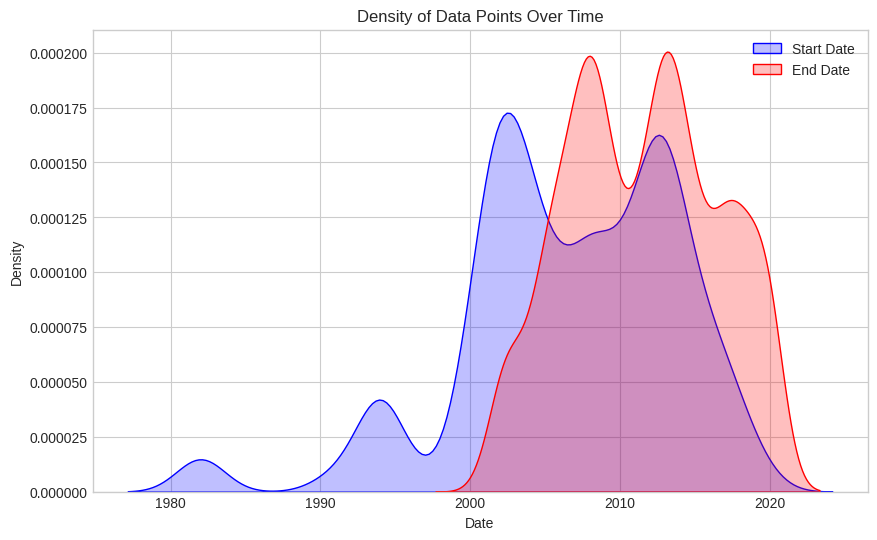

In [20]:
df_=filtered_df
# Convert "YYYY-DOY" format to datetime
df_['Start date'] = pd.to_datetime(df_['Start date'], format='%Y-%j')
df_['End date'] = pd.to_datetime(df_['End date'], format='%Y-%j')

# Create a new DataFrame with individual dates
dates_df = pd.DataFrame({
    'date': pd.date_range(df_['Start date'].min(), df_['End date'].max())
})

# Calculate the density of data points over time
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_['Start date'], color='blue', fill=True, label='Start Date')
sns.kdeplot(data=df_['End date'], color='red', fill=True, label='End Date')
plt.xlabel('Date')
plt.ylabel('Density')
plt.title('Density of Data Points Over Time')
plt.legend()
plt.show()

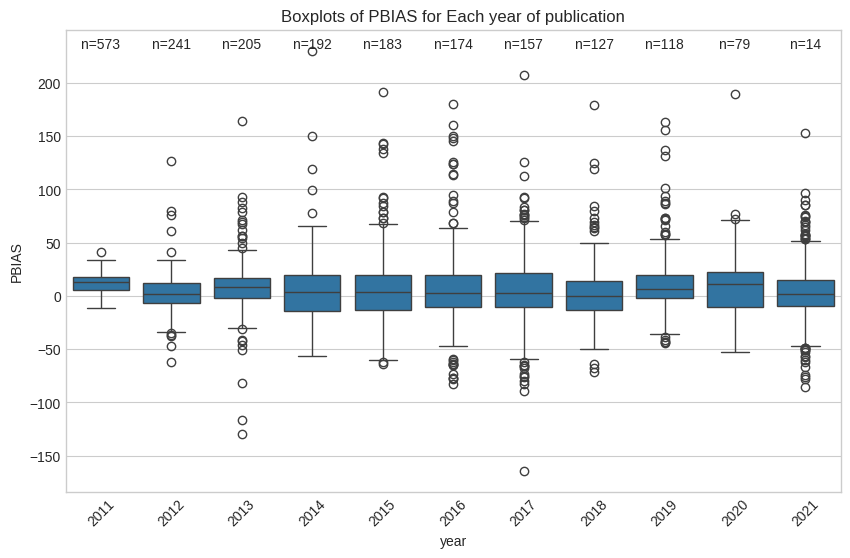

In [21]:
df_ = filtered_df
# Plot boxplots of PBIAS for each model type
plt.figure(figsize=(10, 6))
sns.boxplot(x='year', y='PBIAS (%)', data=df_)

# Annotate the plot with the count of data points for each group
group_counts = df_['year'].value_counts().reset_index()
group_counts.columns = ['year', 'count']
for index, row in group_counts.iterrows():
    plt.text(index, df_['PBIAS (%)'].max() + 2, f'n={row["count"]}', ha='center')

plt.xlabel('year')
plt.ylabel('PBIAS')
plt.title('Boxplots of PBIAS for Each year of publication')
plt.xticks(rotation=45)
plt.show()

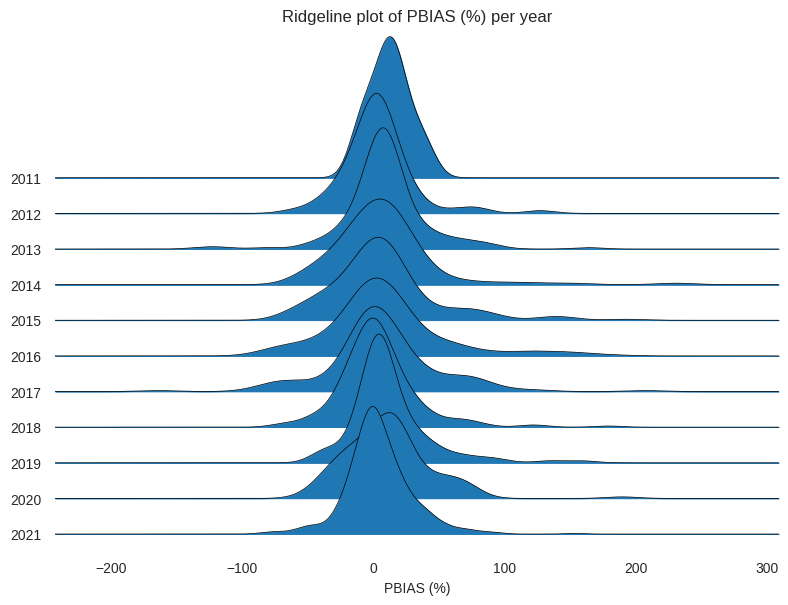

In [22]:
df_year = filtered_df[['year','PBIAS (%)']]
# Create the ridgeline plot using joypy
fig, axes = joypy.joyplot(
    df_year,
    by="year",
    column="PBIAS (%)",
    figsize=(8, 6),
    title="Ridgeline plot of PBIAS (%) per year",
    linewidth=0.5,
    overlap=2
)

# Add labels to the plot
plt.xlabel("PBIAS (%)")
plt.ylabel("Year")

# Display the plot
plt.show()

## Plot distribution by year

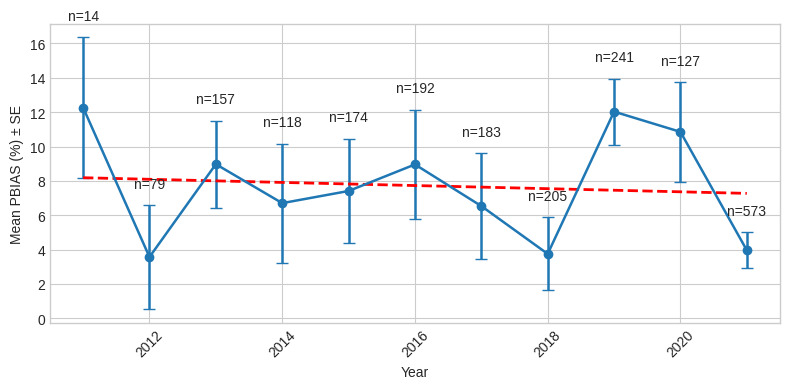

In [23]:
df_ = filtered_df.copy()

# ---------- summary statistics ----------
summary = (df_
           .groupby('year', as_index=False)['PBIAS (%)']
           .agg(mean='mean', std='std', n='count'))
summary['se'] = summary['std'] / np.sqrt(summary['n'])   # standard error

# ---------- line chart with error bars ----------
plt.figure(figsize=(8, 4))
plt.errorbar(
    summary['year'],
    summary['mean'],
    yerr=summary['se'],
    fmt='-o',           # line + round markers
    capsize=4,          # length of error-bar caps
    linewidth=1.8,
    markersize=6
)

# annotate sample sizes
for x, y, s in zip(summary['year'], summary['mean'], summary['n']):
    plt.text(x, y + summary.loc[summary['year'] == x, 'se'].iat[0] + 1,
             f'n={s}', ha='center')


# ---------- fit linear regression line ----------
coeffs = np.polyfit(summary['year'], summary['mean'], deg=1)  # linear fit: y = mx + b
trendline = np.poly1d(coeffs)
x_vals = np.linspace(summary['year'].min(), summary['year'].max(), 100)
y_vals = trendline(x_vals)
# ---------- add regression trend line ----------
plt.plot(x_vals, y_vals, color='red', linestyle='--', linewidth=2, label=f'Regression trend')


plt.xlabel('Year')
plt.ylabel('Mean PBIAS (%) ± SE')
# plt.title('Mean PBIAS by Year with Standard Error')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(save_folder,'2_pbias_by_year.png'), bbox_inches='tight')
plt.show()


## Test if there is significant trend in median and mean PBIAS through out the years

 Kruskal-Wallis test is a non-parametric test used to compare the medians of two or more independent groups. It is used to see if there's a significant difference in the median of the variable across different time periods. The test assumes independent random samples, the distribution shapes are similar across groups (though their medians can differ).

Linear regression is a parametric test that assumes a linear relationship between the variable being tested for a trend (e.g., PBIAS) and time (e.g., year). It's appropriate when the data is approximately normally distributed and the relationship appears linear. It tests if the slope of the line is significantly different from zero. The test assumes normality of residuals, independence of observations, homoscedasticity (equal variances of residuals), linearity.

In [24]:
# Group data by year and calculate median and mean PBIAS
yearly_stats = filtered_df.groupby('year')['PBIAS (%)'].agg(['median', 'mean']).reset_index()

# create a list of PBIAS values for each year
yearly_pbias = [filtered_df['PBIAS (%)'][filtered_df['year'] == year] for year in filtered_df['year'].unique()]

# Perform the Kruskal-Wallis test
h_statistic, p_value_kruskal = kruskal(*yearly_pbias)

print("\nKruskal-Wallis Test for Median PBIAS Trend:")
print("H-Statistic:", h_statistic)
print("P-Value:", p_value_kruskal)

if p_value_kruskal < 0.01:
    print("There is a significant trend in median PBIAS over the years (p < 0.05)")
else:
    print("There is no significant trend in median PBIAS over the years (p >= 0.05)")


# Perform linear regression on yearly mean PBIAS
slope_mean, intercept_mean, r_value_mean, p_value_mean, std_err_mean = linregress(yearly_stats['year'], yearly_stats['mean'])

print("\nLinear Regression for Mean PBIAS Trend:")
print("Slope:", slope_mean)
print("P-Value:", p_value_mean)

if p_value_mean < 0.01:
    print("There is a significant linear trend in mean PBIAS over the years (p < 0.05)")
    if slope_mean > 0:
        print("The trend is increasing.")
    else:
        print("The trend is decreasing.")
else:
    print("There is no significant linear trend in mean PBIAS over the years (p >= 0.05)")

# perform linear regression on yearly median PBIAS for a similar trend analysis
slope_median, intercept_median, r_value_median, p_value_median, std_err_median = linregress(yearly_stats['year'], yearly_stats['median'])

print("\nLinear Regression for Median PBIAS Trend:")
print("Slope:", slope_median)
print("P-Value:", p_value_median)

if p_value_median < 0.01:
    print("There is a significant linear trend in median PBIAS over the years (p < 0.05)")
    if slope_median > 0:
        print("The trend is increasing.")
    else:
        print("The trend is decreasing.")
else:
    print("There is no significant linear trend in median PBIAS over the years (p >= 0.05)")



Kruskal-Wallis Test for Median PBIAS Trend:
H-Statistic: 27.706294339159427
P-Value: 0.0020113138942546107
There is a significant trend in median PBIAS over the years (p < 0.05)

Linear Regression for Mean PBIAS Trend:
Slope: -0.0910022230213348
P-Value: 0.7819576609480849
There is no significant linear trend in mean PBIAS over the years (p >= 0.05)

Linear Regression for Median PBIAS Trend:
Slope: -0.3157346806454545
P-Value: 0.4440771068126489
There is no significant linear trend in median PBIAS over the years (p >= 0.05)



Mann-Kendall is a non-parametric test, meaning it doesn't assume normality or linearity. It's suitable for detecting monotonic trends (either consistently increasing or decreasing) in time series data. It's less sensitive to outliers than parametric tests like linear regression. The test also assumes data are independent, and the variance of the data is constant over time (though variations exist to handle this).

In [25]:
# Group data by year and calculate median and mean PBIAS
yearly_stats = df_.groupby('year')['PBIAS (%)'].agg(['median', 'mean']).reset_index()

# Perform Mann-Kendall test for median PBIAS trend
mk_median = mk.original_test(yearly_stats['median'])

print("\nMann-Kendall Test for Median PBIAS Trend:")
print(f"Mann-Kendall Test Results: {mk_median}")

# Perform Mann-Kendall test for mean PBIAS trend
mk_mean = mk.original_test(yearly_stats['mean'])

print("\nMann-Kendall Test for Mean PBIAS Trend:")
print(f"Mann-Kendall Test Results: {mk_mean}")



Mann-Kendall Test for Median PBIAS Trend:
Mann-Kendall Test Results: Mann_Kendall_Test(trend='no trend', h=np.False_, p=np.float64(0.27575784782750934), z=np.float64(-1.0898985218261321), Tau=np.float64(-0.2727272727272727), s=np.float64(-15.0), var_s=165.0, slope=np.float64(-0.36666666666666653), intercept=np.float64(5.763498055333333))

Mann-Kendall Test for Mean PBIAS Trend:
Mann-Kendall Test Results: Mann_Kendall_Test(trend='no trend', h=np.False_, p=np.float64(0.7554968749288828), z=np.float64(-0.3113995776646092), Tau=np.float64(-0.09090909090909091), s=np.float64(-5.0), var_s=165.0, slope=np.float64(-0.05703983692746414), intercept=np.float64(7.698409400560884))


In [26]:

# Group data by year and calculate median and mean PBIAS
yearly_stats = df_.groupby('year')['PBIAS (%)'].agg(['min', 'max']).reset_index()

# Perform Mann-Kendall test for median PBIAS trend
mk_median = mk.original_test(yearly_stats['min'])

print("\nMann-Kendall Test for Min PBIAS Trend:")
print(f"Mann-Kendall Test Results: {mk_median}")

# Perform Mann-Kendall test for mean PBIAS trend
mk_mean = mk.original_test(yearly_stats['max'])

print("\nMann-Kendall Test for Max PBIAS Trend:")
print(f"Mann-Kendall Test Results: {mk_mean}")



Mann-Kendall Test for Min PBIAS Trend:
Mann-Kendall Test Results: Mann_Kendall_Test(trend='no trend', h=np.False_, p=np.float64(0.5334165134726945), z=np.float64(-0.6227991553292184), Tau=np.float64(-0.16363636363636364), s=np.float64(-9.0), var_s=165.0, slope=np.float64(-2.603921568888889), intercept=np.float64(-51.28039215555555))

Mann-Kendall Test for Max PBIAS Trend:
Mann-Kendall Test Results: Mann_Kendall_Test(trend='no trend', h=np.False_, p=np.float64(0.7554968749288828), z=np.float64(0.3113995776646092), Tau=np.float64(0.09090909090909091), s=np.float64(5.0), var_s=165.0, slope=np.float64(3.030000000000001), intercept=np.float64(163.85))


# Validation Duration

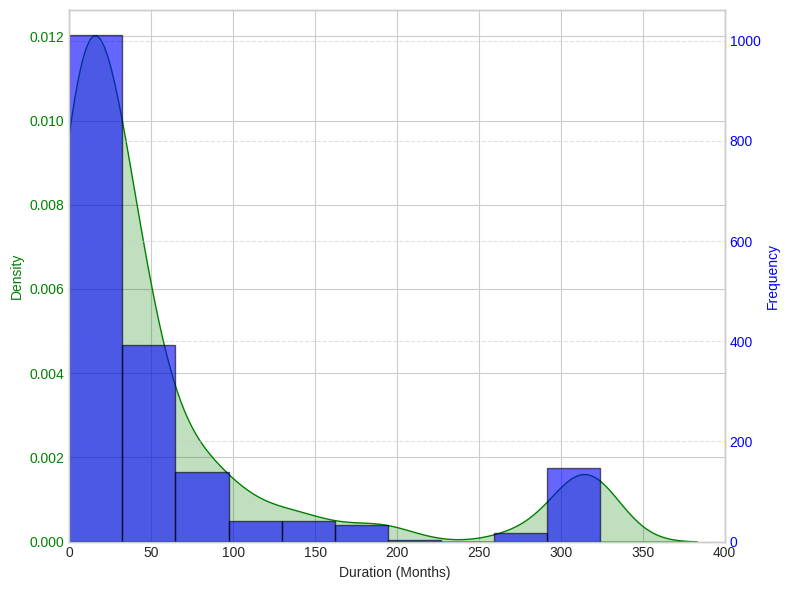

In [27]:
# Calculate the duration between start date and end date
df_ = filtered_df.copy()
df_['duration'] = (df_['End date'] - df_['Start date']).dt.days
df_['duration_months'] = df_['duration'] / 30.4375

# Create a figure and a primary axes
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot the KDE plot on the primary axes (ax1)
sns.kdeplot(data=df_['duration_months'], color='green', fill=True, ax=ax1)
ax1.set_xlabel('Duration (Months) ')
ax1.set_ylabel('Density', color='green')
ax1.tick_params(axis='y', labelcolor='green')
ax1.set_xlim(0,400)

# Create a secondary axes that shares the same x-axis
ax2 = ax1.twinx()

# Plot the histogram on the secondary axes (ax2)
ax2.hist(df_['duration_months'], bins=10, color='blue', edgecolor='black', alpha=0.6)
ax2.set_ylabel('Frequency', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# plt.title('Density and Frequency of Durations between Start Date and End Date')
plt.grid(True, axis='y', linestyle='--', alpha=0.6) # Add grid for frequency
fig.tight_layout() # Adjust layout
plt.show()

In [28]:
negative_duration_rows = df_[df_['duration'] < 0]

# Display the rows where duration is negative
print(negative_duration_rows['record_id'])

Series([], Name: record_id, dtype: int64)


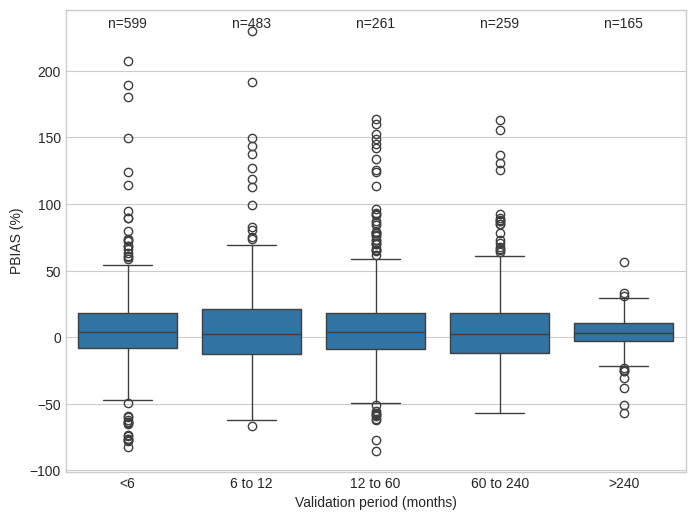

In [29]:
df_ = filtered_df.copy()
df_['duration'] = (df_['End date'] - df_['Start date']).dt.days
df_['duration_months'] = df_['duration'] / 30.4375

# Group data into 3 groups based on duration in months
df_['duration_group'] = pd.cut(df_['duration_months'], bins=[0,6, 12, 60, 240, float('inf')], labels=['<6','6 to 12','12 to 60', '60 to 240', '>240'])

# Plot boxplot of "pbias (%)" for each group
plt.figure(figsize=(8, 6))
sns.boxplot(x='duration_group', y='PBIAS (%)', data=df_)

# Annotate the plot with the count of data points for each group
group_counts = df_['duration_group'].value_counts().reset_index()
group_counts.columns = ['duration_group', 'count']
for index, row in group_counts.iterrows():
    plt.text(index, df_['PBIAS (%)'].max() + 2, f'n={row["count"]}', ha='center')

plt.xlabel('Validation period (months)')
plt.ylabel('PBIAS (%)')
# plt.title('Boxplot of PBIAS (%) for Duration Groups')
plt.savefig(os.path.join(save_folder,'3_pbias_by_duration.png'), bbox_inches='tight')
plt.show()

no significant difference between groups

In [30]:
# Perform one-way ANOVA
anova_result = f_oneway(df_[df_['duration_group'] == '<6']['PBIAS (%)'],
                        df_[df_['duration_group'] == '6 to 12']['PBIAS (%)'],
                        df_[df_['duration_group'] == '12 to 60']['PBIAS (%)'],
                        df_[df_['duration_group'] == '60 to 240']['PBIAS (%)'],
                        df_[df_['duration_group'] == '>240']['PBIAS (%)'])

# Print the ANOVA result
print("ANOVA F-Statistic:", anova_result.statistic)
print("ANOVA p-value:", anova_result.pvalue)

# Check for significance
if anova_result.pvalue < 0.05:
    print("There is a significant difference between the groups (p < 0.05)")
else:
    print("There is no significant difference between the groups (p >= 0.05)")

ANOVA F-Statistic: 1.217293456154228
ANOVA p-value: 0.30140877409612044
There is no significant difference between the groups (p >= 0.05)


In [31]:
# Perform Kruskal-Wallis H-test
kruskal_result = kruskal(df_[df_['duration_group'] == '<6']['PBIAS (%)'],
                         df_[df_['duration_group'] == '6 to 12']['PBIAS (%)'],
                        df_[df_['duration_group'] == '12 to 60']['PBIAS (%)'],
                        df_[df_['duration_group'] == '60 to 240']['PBIAS (%)'],
                        df_[df_['duration_group'] == '>240']['PBIAS (%)'])


# Print the Kruskal-Wallis test result
print("Kruskal-Wallis H-Statistic:", kruskal_result.statistic)
print("Kruskal-Wallis p-value:", kruskal_result.pvalue)

# Check for significance
if kruskal_result.pvalue < 0.05:
    print("There is a significant difference in the distribution of the groups (p < 0.05)")
else:
    print("There is no significant difference in the distribution of the groups (p >= 0.05)")

Kruskal-Wallis H-Statistic: 3.2351036318262936
Kruskal-Wallis p-value: 0.5192798368763932
There is no significant difference in the distribution of the groups (p >= 0.05)


# Model types

In [32]:
# Define a list of values to filter
values_to_filter = ['1SEB', '2SEB', 'PM','PT', 'Empirical' , 'Factor', 'Ts-VI','Others'] # valid Model types

# Filter rows with values in the "model types" column
df_models = filtered_df[filtered_df['Model Type'].isin(values_to_filter)]

In [33]:
df_models.to_csv('PBIAS_by_model_Type.csv')

## Boxplots

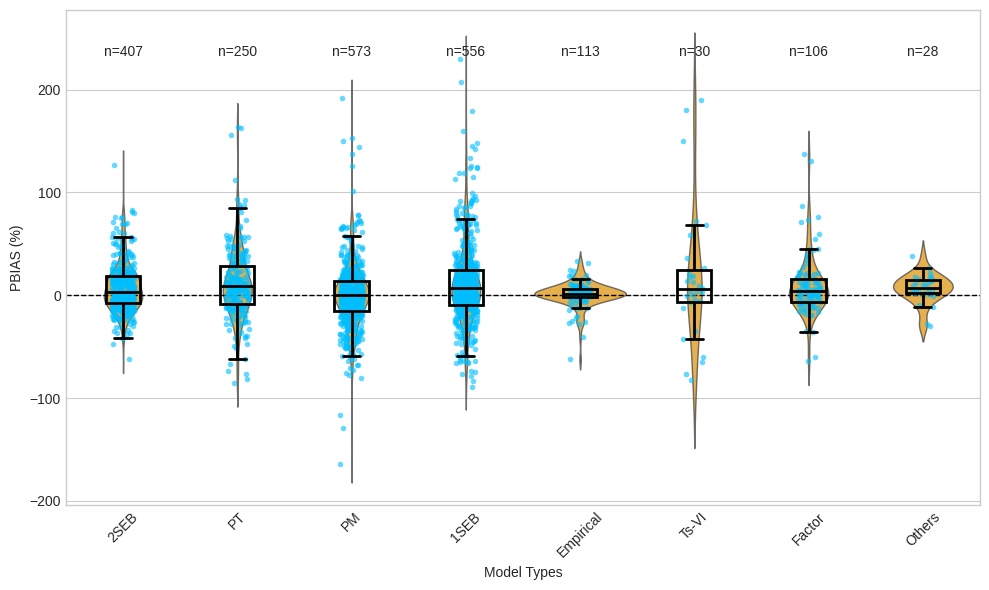

In [34]:
df_ = df_models

# Set up the plot
plt.figure(figsize=(10, 6))



# Then plot the strip plot on top
sns.stripplot(
    x='Model Type', y='PBIAS (%)', data=df_,
    color='deepskyblue', jitter=True, size=4, alpha=0.6
)

# Plot violin plot first (as smooth KDE background, with no internal box)
sns.violinplot(
    x='Model Type', y='PBIAS (%)', data=df_,
    inner=None, linewidth=1, color='orange', alpha=0.8
)
# Overlay boxplot (no fill, sharp outline)
sns.boxplot(
    x='Model Type', y='PBIAS (%)', data=df_,
    width=0.3, showcaps=True, showfliers=False,
    boxprops=dict(facecolor='none', edgecolor='black', linewidth=2, zorder=3),
    whiskerprops=dict(color='black', linewidth=2, zorder=3),
    capprops=dict(color='black', linewidth=2, zorder=3),
    medianprops=dict(color='black', linewidth=2, zorder=3)
)

# Annotate group sizes
group_counts = df_['Model Type'].value_counts().reset_index()
group_counts.columns = ['Model Type', 'count']
model_order = df_['Model Type'].unique()

for i, model_type in enumerate(model_order):
    count = group_counts[group_counts['Model Type'] == model_type]['count'].values[0]
    plt.text(i, df_['PBIAS (%)'].max() + 2, f'n={count}', ha='center')

# Labels and title
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Model Types')
plt.ylabel('PBIAS (%)')
# plt.yscale('symlog', linthresh=1) # Set y-axis to symmetric log scale to handle negative values
# plt.title('Violin + Strip + Outline Boxplot of PBIAS for Each Model Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

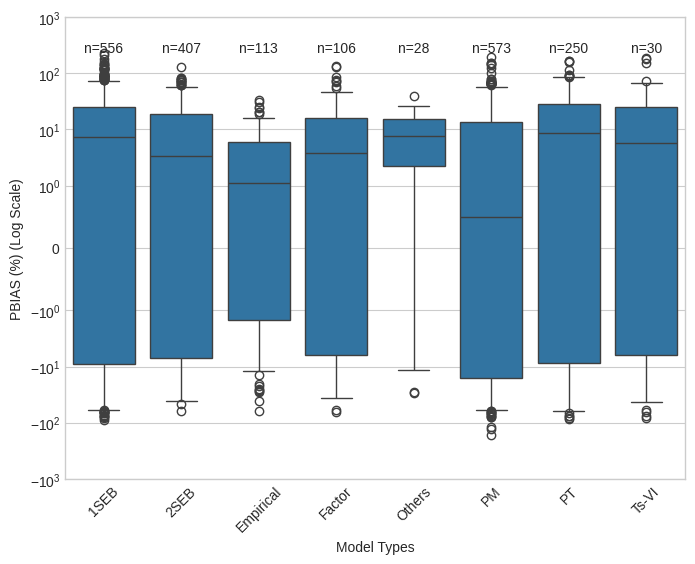

In [35]:
df_ = df_models
# Plot boxplots of PBIAS for each model type
plt.figure(figsize=(8, 6))
# Define the desired order for the x-axis
model_order = ['1SEB', '2SEB', 'Empirical', 'Factor', 'Others', 'PM', 'PT', 'Ts-VI']
sns.boxplot(x='Model Type', y='PBIAS (%)', data=df_, order=model_order)

# Annotate the plot with the count of data points for each group
group_counts = df_['Model Type'].value_counts().reset_index()
group_counts.columns = ['Model Type', 'count']
# Ensure group_counts is in the same order as model_order for correct annotation placement
group_counts = group_counts.set_index('Model Type').loc[model_order].reset_index()


for index, row in group_counts.iterrows():
    # Adjust text placement slightly if needed based on the log scale
    plt.text(index, df_['PBIAS (%)'].max() + 2, f'n={row["count"]}', ha='center')


plt.xlabel('Model Types')
plt.ylabel('PBIAS (%) (Log Scale)') # Update y-axis label
# plt.title('Boxplots of PBIAS (%) for Each Model Type (Log Scale)') # Update title
plt.xticks(rotation=45)
plt.yscale('symlog', linthresh=1) # Set y-axis to symmetric log scale to handle negative values
plt.ylim(-1000,1000)
plt.savefig(os.path.join(save_folder,'4_pbias_by_model_type.png'), bbox_inches='tight')
plt.show()

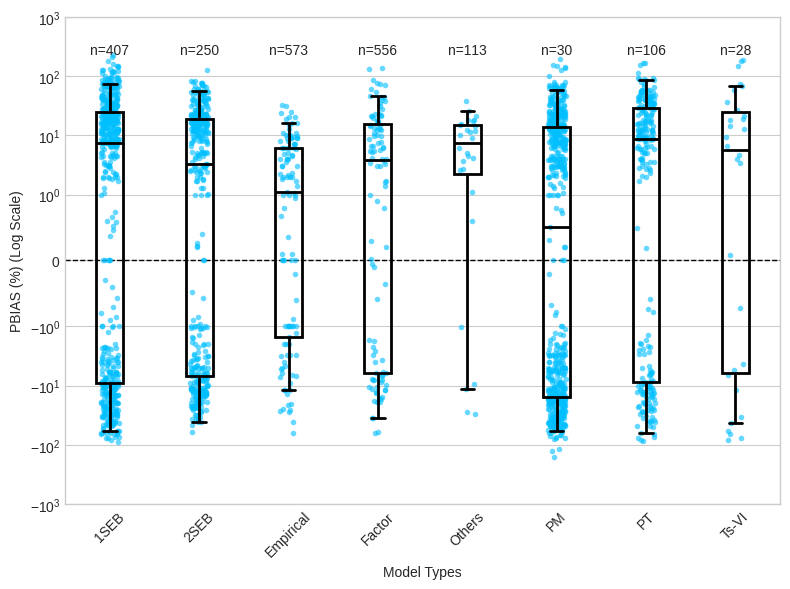

In [36]:


df_ = df_models

# Set up the plot
plt.figure(figsize=(8, 6))
model_order = ['1SEB', '2SEB', 'Empirical', 'Factor', 'Others', 'PM', 'PT', 'Ts-VI']
# Plot strip plot first (so it's underneath)
sns.stripplot(x='Model Type', y='PBIAS (%)', data=df_,
              color='deepskyblue', jitter=True, size=4, alpha=0.6,order=model_order)

# Overlay boxplot with no fill and thicker, brighter outline
sns.boxplot(
    x='Model Type', y='PBIAS (%)', data=df_,
    width=0.3, showcaps=True, showfliers=False,
    boxprops=dict(facecolor='none', edgecolor='black', linewidth=2, zorder=3),
    whiskerprops=dict(color='black', linewidth=2, zorder=3),
    capprops=dict(color='black', linewidth=2, zorder=3),
    medianprops=dict(color='black', linewidth=2, zorder=3)
)

# Annotate group sizes
group_counts = df_['Model Type'].value_counts().reset_index()
group_counts.columns = ['Model Type', 'count']
model_order = df_['Model Type'].unique()

for i, model_type in enumerate(model_order):
    count = group_counts[group_counts['Model Type'] == model_type]['count'].values[0]
    plt.text(i, df_['PBIAS (%)'].max() + 2, f'n={count}', ha='center')

# Labels and title
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Model Types')
plt.ylabel('PBIAS (%) (Log Scale)') # Update y-axis label
plt.yscale('symlog', linthresh=1) # Set y-axis to symmetric log scale to handle negative values
plt.ylim(-1000,1000)
# plt.title('Strip Plot + Outline Boxplot of PBIAS for Each Model Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(save_folder,'4_pbias_by_model_type.png'), bbox_inches='tight')
plt.show()


In [37]:
df_model_types =  df_[['Model Type','PBIAS (%)']]
df_model_types

,Model Type,PBIAS (%)
0,2SEB,13.100000
1,2SEB,8.000000
2,2SEB,19.400000
3,2SEB,14.600000
4,2SEB,8.200000
...,...,...
2065,2SEB,-3.200000
2066,2SEB,0.400000
2067,2SEB,5.200001
2068,2SEB,80.999988


## Sample size

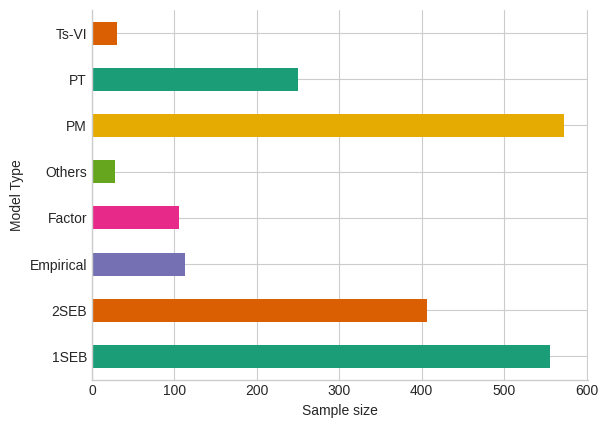

In [38]:
df_model_types.groupby('Model Type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.xlabel('Sample size')
plt.gca().spines[['top', 'right',]].set_visible(False)

## Descriptive statistics

In [39]:
# Group the data by 'Model Type' and calculate descriptive statistics for 'PBIAS (%)'
df_model_types_stats= df_model_types.groupby('Model Type')['PBIAS (%)'].describe()
df_model_types_stats

,count,mean,std,min,25%,50%,75%,max
Model Type,,,,,,,,
1SEB,556.0,11.675331,39.340809,-89.000000,-9.000000,7.314921,24.563953,230.279898
2SEB,407.0,7.447586,23.221776,-61.764706,-7.035354,3.300000,18.840336,127.000000
Empirical,113.0,0.960544,12.462327,-62.409639,-1.500000,1.100000,6.000000,33.000000
Factor,106.0,9.311970,29.226439,-64.300000,-6.139959,3.814540,15.746875,137.000000
Others,28.0,6.767544,14.399628,-30.000000,2.225000,7.500000,15.200000,38.600000
PM,573.0,0.054135,32.290089,-164.000000,-15.753425,0.500000,13.770000,191.601743
PT,250.0,11.339265,34.898677,-85.200000,-8.684091,8.623937,28.904155,163.850000
Ts-VI,30.0,16.827008,65.169103,-82.583708,-6.269551,5.680000,25.036191,189.600000


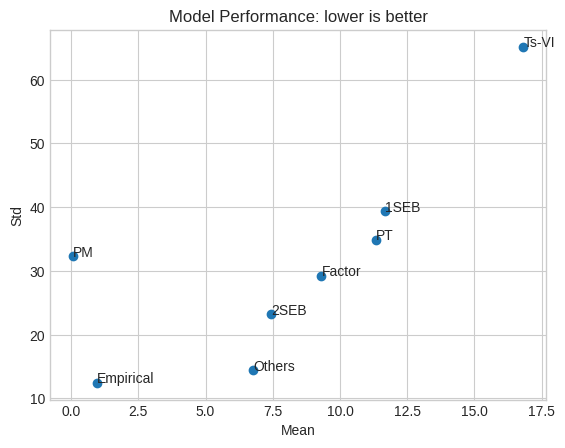

In [40]:
ms = df_model_types_stats['mean']
ss = df_model_types_stats['std']
labels = df_model_types_stats.index

plt.scatter(ms, ss)
for x,y,label in zip(ms,ss,labels):
    plt.text(x, y, label)
plt.xlabel("Mean")
plt.ylabel("Std")
plt.title("Model Performance: lower is better")
plt.show()


Ranking model type by distance from the origin of mean-std graph

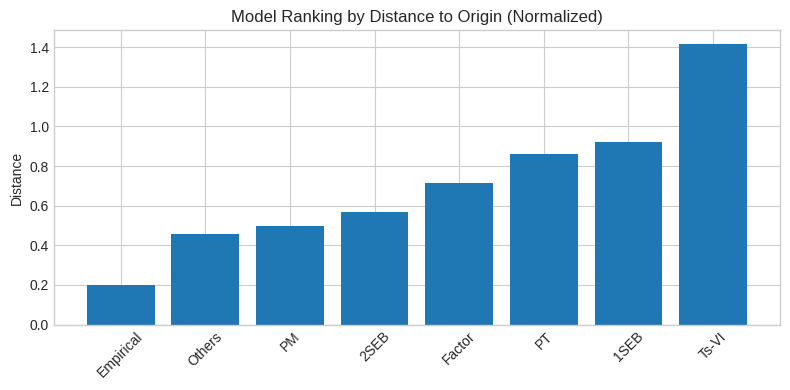

In [41]:
# Normalize mean and std
df_model_types_stats['Mean_norm'] = df_model_types_stats['mean'] / df_model_types_stats['mean'].max()
df_model_types_stats['Std_norm'] = df_model_types_stats['std'] / df_model_types_stats['std'].max()

# Compute Euclidean distance
df_model_types_stats['Distance'] = np.sqrt(df_model_types_stats['Mean_norm']**2 + df_model_types_stats['Std_norm']**2)

# Sort by best (lowest distance)
df_sorted = df_model_types_stats.sort_values('Distance')

# Bar plot
plt.figure(figsize=(8, 4))
plt.bar(df_sorted.index, df_sorted['Distance'])
plt.title('Model Ranking by Distance to Origin (Normalized)')
plt.ylabel('Distance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Ranking model type by sum of mean rank and std rank

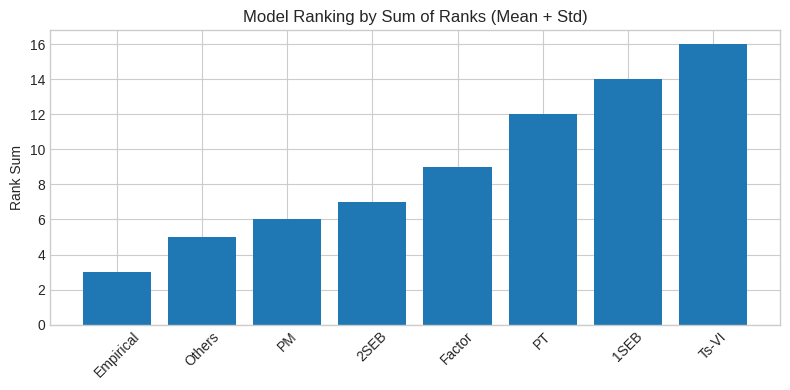

In [42]:
# Ranking
df_model_types_stats['Mean_rank'] = df_model_types_stats['mean'].rank()
df_model_types_stats['Std_rank'] = df_model_types_stats['std'].rank()
df_model_types_stats['RankSum'] = df_model_types_stats['Mean_rank'] + df_model_types_stats['Std_rank']

# Sort by RankSum
df_sorted = df_model_types_stats.sort_values('RankSum')

# Bar plot
plt.figure(figsize=(8, 4))
plt.bar(df_sorted.index, df_sorted['RankSum'])
plt.title('Model Ranking by Sum of Ranks (Mean + Std)')
plt.ylabel('Rank Sum')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


calculates and visualizes the Pareto front for different model types based on their mean and standard deviation of PBIAS, to identify the Pareto-efficient points.

A point is Pareto-efficient if there is no other point that is better in both 'mean' and 'std' (assuming lower is better for both).

The models on the Pareto front (colored green) are those that are not outperformed by any other model in both mean and standard deviation simultaneously. These models represent the best trade-offs between bias (mean) and variability (std).

/tmp/ipython-input-2441412982.py:20: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



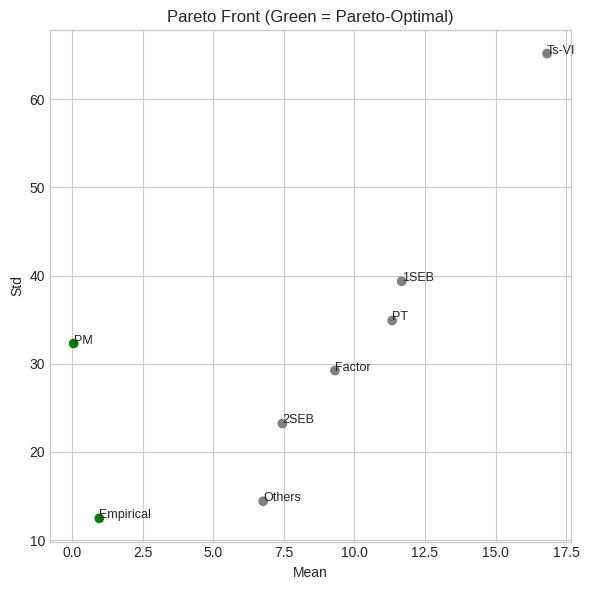

In [43]:
# Pareto front calculation
def is_pareto_efficient(df):
    is_efficient = np.ones(df.shape[0], dtype=bool)
    for i, (m, s) in enumerate(zip(df['mean'], df['std'])):
        if is_efficient[i]:
            is_efficient[is_efficient] = ~(
                (df['mean'][is_efficient] > m) &
                (df['std'][is_efficient] > s)
            )
            is_efficient[i] = True
    return is_efficient
df_ = df_model_types_stats.copy()
df_['Pareto'] = is_pareto_efficient(df_)

# Plot
colors = ['green' if x else 'gray' for x in df_['Pareto']]
plt.figure(figsize=(6,6))
plt.scatter(df_['mean'], df_['std'], c=colors)
for i in range(len(df_)):
    plt.text(df_['mean'][i], df_['std'][i], df_.index[i], fontsize=9)
plt.xlabel('Mean')
plt.ylabel('Std')
plt.title('Pareto Front (Green = Pareto-Optimal)')
plt.grid(True)
plt.tight_layout()
plt.show()


## Normal distribution test

In [44]:
# Group data by 'Model Type'
grouped_data = df_model_types.groupby('Model Type')

# Iterate over each group
results = {}
for name, group in grouped_data:
    # Normalize the 'PBIAS (%)' data for the current group by subtracting the mean
    normalized_data = group['PBIAS (%)'] - group['PBIAS (%)'].mean()

    # Perform the Shapiro-Wilk test for normality
    statistic, p_value = stats.shapiro(group['PBIAS (%)'])
    # Store the results (S-W statistic and p-value)
    results[name] = {'SW Statistic': statistic, 'P-value': p_value}

# Print the results for each 'Model Type'
for model_type, result in results.items():
    print(f"Model Type: {model_type}")
    print(f"  Shapiro-Wilk Statistic: {result['SW Statistic']:.4f}")
    print(f"  P-value: {result['P-value']:.4f}")
    # Interpret the p-value (common alpha level is 0.05)
    if result['P-value'] < 0.05:
        print("  Interpretation: The distribution is likely not normal (reject null hypothesis).")
    else:
        print("  Interpretation: The distribution is likely normal (fail to reject null hypothesis).")
    print("-" * 30)

Model Type: 1SEB
  Shapiro-Wilk Statistic: 0.9114
  P-value: 0.0000
  Interpretation: The distribution is likely not normal (reject null hypothesis).
------------------------------
Model Type: 2SEB
  Shapiro-Wilk Statistic: 0.9475
  P-value: 0.0000
  Interpretation: The distribution is likely not normal (reject null hypothesis).
------------------------------
Model Type: Empirical
  Shapiro-Wilk Statistic: 0.8593
  P-value: 0.0000
  Interpretation: The distribution is likely not normal (reject null hypothesis).
------------------------------
Model Type: Factor
  Shapiro-Wilk Statistic: 0.8341
  P-value: 0.0000
  Interpretation: The distribution is likely not normal (reject null hypothesis).
------------------------------
Model Type: Others
  Shapiro-Wilk Statistic: 0.9334
  P-value: 0.0751
  Interpretation: The distribution is likely normal (fail to reject null hypothesis).
------------------------------
Model Type: PM
  Shapiro-Wilk Statistic: 0.9087
  P-value: 0.0000
  Interpretation

In [45]:
# Group data by 'Model Type'
grouped_data = df_model_types.groupby('Model Type')

# Iterate over each group
results = {}
for name, group in grouped_data:
    # Normalize the 'PBIAS (%)' data for the current group by subtracting the mean
    normalized_data = group['PBIAS (%)'] - group['PBIAS (%)'].mean()

    # Perform the Kolmogorov-Smirnov test for normality on the normalized data
    ks_statistic, p_value = stats.kstest(normalized_data, 'norm')

    # Store the results (KS statistic and p-value)
    results[name] = {'KS Statistic': ks_statistic, 'P-value': p_value}

# Print the results for each 'Model Type'
for model_type, result in results.items():
    print(f"Model Type: {model_type}")
    print(f"  Kolmogorov-Smirnov Statistic: {result['KS Statistic']:.4f}")
    print(f"  P-value: {result['P-value']:.4f}")
    # Interpret the p-value (common alpha level is 0.05)
    if result['P-value'] < 0.05:
        print("  Interpretation: The distribution is likely not normal (reject null hypothesis).")
    else:
        print("  Interpretation: The distribution is likely normal (fail to reject null hypothesis).")
    print("-" * 30)

Model Type: 1SEB
  Kolmogorov-Smirnov Statistic: 0.5473
  P-value: 0.0000
  Interpretation: The distribution is likely not normal (reject null hypothesis).
------------------------------
Model Type: 2SEB
  Kolmogorov-Smirnov Statistic: 0.5285
  P-value: 0.0000
  Interpretation: The distribution is likely not normal (reject null hypothesis).
------------------------------
Model Type: Empirical
  Kolmogorov-Smirnov Statistic: 0.3864
  P-value: 0.0000
  Interpretation: The distribution is likely not normal (reject null hypothesis).
------------------------------
Model Type: Factor
  Kolmogorov-Smirnov Statistic: 0.5994
  P-value: 0.0000
  Interpretation: The distribution is likely not normal (reject null hypothesis).
------------------------------
Model Type: Others
  Kolmogorov-Smirnov Statistic: 0.4835
  P-value: 0.0000
  Interpretation: The distribution is likely not normal (reject null hypothesis).
------------------------------
Model Type: PM
  Kolmogorov-Smirnov Statistic: 0.4480
  

/tmp/ipython-input-4242541672.py:28: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




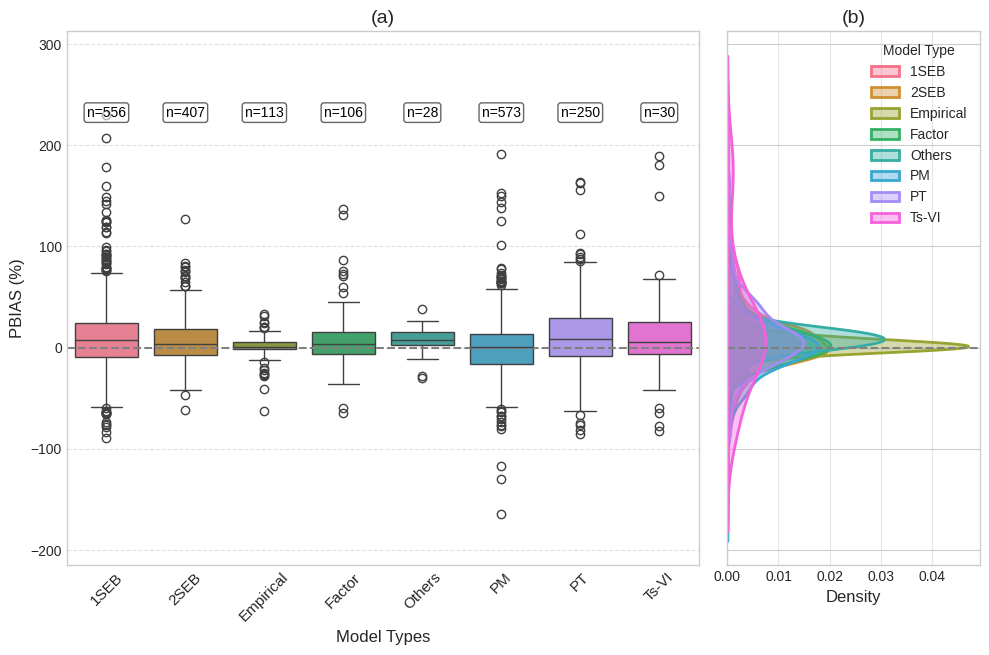

In [46]:
df_ = filtered_df
# Get a sorted list of unique model types for consistent ordering and coloring
model_types = sorted(df_['Model Type'].unique())

# Define a color palette as a dictionary to map each model type to a specific color
colors = sns.color_palette('husl', len(model_types))
color_palette = dict(zip(model_types, colors))


# --- MODIFICATION HERE ---
# To make the right panel narrower, we use gridspec_kw to set the width ratios.
# '[2.5, 1]' makes the left panel 2.5 times wider than the right panel.
# The overall figsize is also adjusted for a better presentation.
fig, (ax1, ax2) = plt.subplots(
    1, 2,
    figsize=(10, 7),
    sharey=True,
    gridspec_kw={'width_ratios': [2.5, 1]}
)

# fig.suptitle('Comparison of PBIAS (%) Distribution by Model Type', fontsize=16, y=0.98)


# --- Plot 1: Boxplots (left subplot) ---'
# Plot strip plot first (so it's underneath)
# sns.stripplot(x='Model Type', y='PBIAS (%)', data=df_, ax=ax1,
#               palette=color_palette, order=model_types, jitter=True, size=4, alpha=0.6)
sns.boxplot(x='Model Type', y='PBIAS (%)', data=df_, ax=ax1, palette=color_palette, order=model_types)
ax1.axhline(0, color='grey', linestyle='--', linewidth=1.5)

# Annotate with data point counts
group_counts = df_['Model Type'].value_counts()
plot_ymin, plot_ymax = ax1.get_ylim()
text_y_pos = plot_ymax - (plot_ymax - plot_ymin) * 0.05

for i, model_type in enumerate(model_types):
    count = group_counts[model_type]
    ax1.text(i, text_y_pos, f'n={count}', ha='center', color='black', bbox=dict(facecolor='white', alpha=0.6, boxstyle='round,pad=0.2'))

ax1.set_xlabel('Model Types', fontsize=12)
ax1.set_ylabel('PBIAS (%)', fontsize=12)
ax1.set_title('(a)', fontsize=14)
ax1.tick_params(axis='x', rotation=45, labelsize=11)
ax1.grid(True, axis='y', linestyle='--', alpha=0.6)


# --- Plot 2: Rotated KDE Plots (right subplot) ---
for model_type in model_types:
    model_data = df_[df_['Model Type'] == model_type]['PBIAS (%)'].dropna()
    sns.kdeplot(
        y=model_data,
        label=model_type,
        color=color_palette[model_type],
        linewidth=2,
        fill=True,
        alpha=0.4,
        ax=ax2
    )

ax2.axhline(0, color='grey', linestyle='--', linewidth=1.5)
ax2.set_xlabel('Density', fontsize=12)
ax2.set_title('(b)', fontsize=14)
ax2.legend(title='Model Type')
ax2.grid(True, axis='x', alpha=0.5)

# plt.yscale('symlog', linthresh=1) # Set y-axis to symmetric log scale to handle negative values
# --- Final adjustments and display ---
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Test difference between the model types

In [47]:
df_ = filtered_df
# Perform one-way ANOVA
anova_result = f_oneway(df_[df_['Model Type'] == '2SEB']['PBIAS (%)'],
                        df_[df_['Model Type'] == '1SEB']['PBIAS (%)'],
                        df_[df_['Model Type'] == 'PT']['PBIAS (%)'],
                        df_[df_['Model Type'] == 'PM']['PBIAS (%)'],
                        df_[df_['Model Type'] == 'Empirical']['PBIAS (%)'],
                        df_[df_['Model Type'] == 'Factor']['PBIAS (%)'],
                        df_[df_['Model Type'] == 'Others']['PBIAS (%)'],
                        df_[df_['Model Type'] == 'Ts-VI']['PBIAS (%)'],
                        )

# Print the ANOVA result
print("ANOVA F-Statistic:", anova_result.statistic)
print("ANOVA p-value:", anova_result.pvalue)

# Check for significance
if anova_result.pvalue < 0.05:
    print("There is a significant difference between the groups (p < 0.05)")
else:
    print("There is no significant difference between the groups (p >= 0.05)")

ANOVA F-Statistic: 6.915504663396035
ANOVA p-value: 3.715751574932343e-08
There is a significant difference between the groups (p < 0.05)


In [48]:
df_ = filtered_df
# Perform Kruskal-Wallis H-test
kruskal_result = kruskal(df_[df_['Model Type'] == '2SEB']['PBIAS (%)'],
                        df_[df_['Model Type'] == '1SEB']['PBIAS (%)'],
                        df_[df_['Model Type'] == 'PT']['PBIAS (%)'],
                        df_[df_['Model Type'] == 'PM']['PBIAS (%)'],
                        df_[df_['Model Type'] == 'Empirical']['PBIAS (%)'],
                        df_[df_['Model Type'] == 'Factor']['PBIAS (%)'],
                        df_[df_['Model Type'] == 'Others']['PBIAS (%)'],
                         df_[df_['Model Type'] == 'Ts-VI']['PBIAS (%)'],
                         )


# Print the Kruskal-Wallis test result
print("Kruskal-Wallis H-Statistic:", kruskal_result.statistic)
print("Kruskal-Wallis p-value:", kruskal_result.pvalue)

# Check for significance
if kruskal_result.pvalue < 0.05:
    print("There is a significant difference in the distribution of the groups (p < 0.05)")
else:
    print("There is no significant difference in the distribution of the groups (p >= 0.05)")

Kruskal-Wallis H-Statistic: 45.71967984512718
Kruskal-Wallis p-value: 9.911463145699649e-08
There is a significant difference in the distribution of the groups (p < 0.05)


## Quantile plot

A graph that visualizes what the Kruskal-Wallis test is testing for is the quantile plot. A quantile plot for natural logarithms of the
"Model Type" groups of "PBIAS (%)" data is shown.

/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning:

invalid value encountered in log



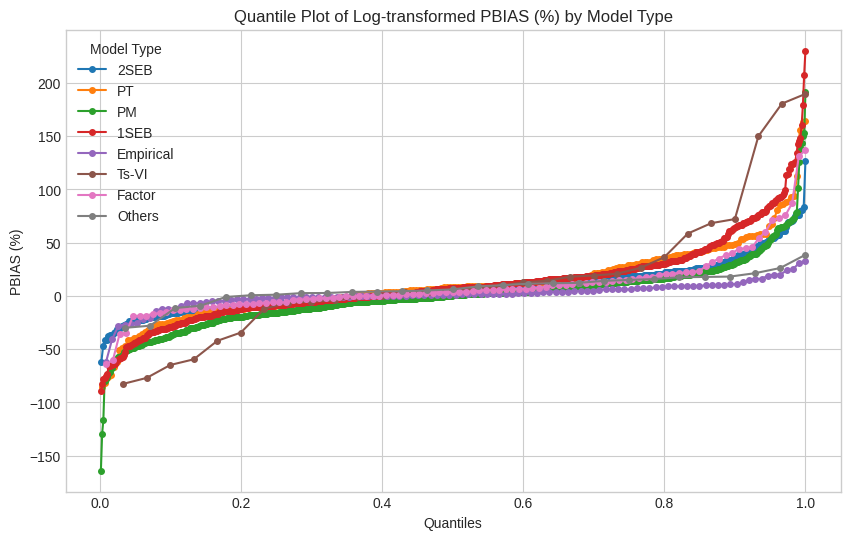

In [49]:
# Calculate the natural logarithm of 'PBIAS (%)'
df_model_types['log_PBIAS'] = np.log(df_model_types['PBIAS (%)'])

# Get the unique model types
model_types = df_model_types['Model Type'].unique()

# Set up the figure and axes
plt.figure(figsize=(10, 6))

# Iterate through each model type and plot the quantile plot
for model_type in model_types:
    # Filter the data for the current model type
    data = df_model_types[df_model_types['Model Type'] == model_type]['PBIAS (%)'].dropna()

    # Sort the data
    sorted_data = np.sort(data)

    # Calculate the quantiles
    quantiles = np.arange(1, len(sorted_data) + 1) / len(sorted_data)

    # Plot the quantile plot
    plt.plot(quantiles, sorted_data, marker='o', linestyle='-', label=model_type, markersize=4)

# Add labels and title
plt.xlabel('Quantiles')
plt.ylabel('PBIAS (%)')
plt.title('Quantile Plot of Log-transformed PBIAS (%) by Model Type')
plt.legend(title='Model Type')
plt.grid(True)
plt.show()

/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning:

invalid value encountered in log



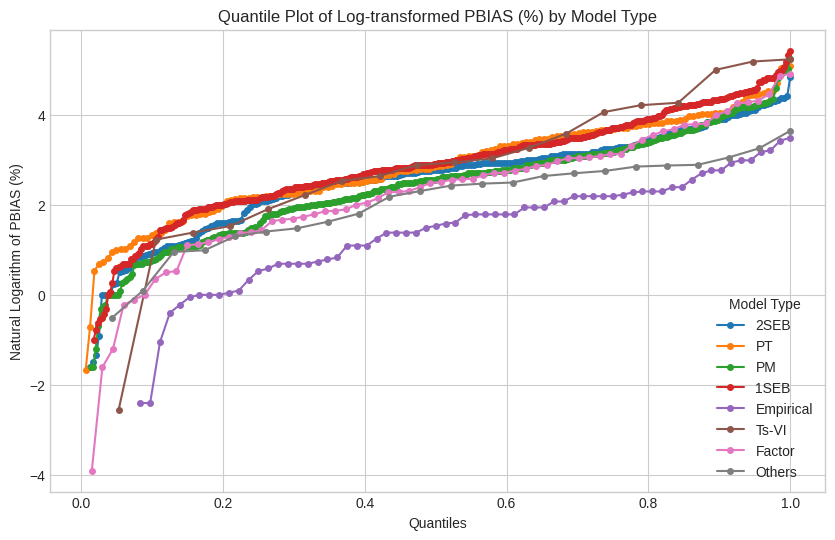

In [50]:

# Calculate the natural logarithm of 'PBIAS (%)'
df_model_types['log_PBIAS'] = np.log(df_model_types['PBIAS (%)'])

# Get the unique model types
model_types = df_model_types['Model Type'].unique()

# Set up the figure and axes
plt.figure(figsize=(10, 6))

# Iterate through each model type and plot the quantile plot
for model_type in model_types:
    # Filter the data for the current model type
    data = df_model_types[df_model_types['Model Type'] == model_type]['log_PBIAS'].dropna()

    # Sort the data
    sorted_data = np.sort(data)

    # Calculate the quantiles
    quantiles = np.arange(1, len(sorted_data) + 1) / len(sorted_data)

    # Plot the quantile plot
    plt.plot(quantiles, sorted_data, marker='o', linestyle='-', label=model_type, markersize=4)

# Add labels and title
plt.xlabel('Quantiles')
plt.ylabel('Natural Logarithm of PBIAS (%)')
plt.title('Quantile Plot of Log-transformed PBIAS (%) by Model Type')
plt.legend(title='Model Type')
plt.grid(True)
plt.show()

## Pair-wise difference test

In [51]:
df_ = filtered_df
dunn_results = sp.posthoc_dunn(df_, val_col='PBIAS (%)', group_col='Model Type', p_adjust='holm')
dunn_results


,1SEB,2SEB,Empirical,Factor,Others,PM,PT,Ts-VI
1SEB,1.000000e+00,1.000000,0.196978,1.00000,1.000000,9.582505e-07,1.000000,1.0
2SEB,1.000000e+00,1.000000,1.000000,1.00000,1.000000,1.211455e-03,1.000000,1.0
Empirical,1.969782e-01,1.000000,1.000000,1.00000,1.000000,1.000000e+00,0.125541,1.0
Factor,1.000000e+00,1.000000,1.000000,1.00000,1.000000,1.942197e-01,1.000000,1.0
Others,1.000000e+00,1.000000,1.000000,1.00000,1.000000,8.161370e-01,1.000000,1.0
PM,9.582505e-07,0.001211,1.000000,0.19422,0.816137,1.000000e+00,0.000020,1.0
PT,1.000000e+00,1.000000,0.125541,1.00000,1.000000,1.995505e-05,1.000000,1.0
Ts-VI,1.000000e+00,1.000000,1.000000,1.00000,1.000000,1.000000e+00,1.000000,1.0


In [52]:
# Assuming a significance level of 0.05, print a summary of Dunn's test results
alpha = 0.05

# Iterate through the columns of the dataframe (which represent the pairwise comparisons)
for column in dunn_results.columns:
    # Iterate through the rows (which also represent the pairwise comparisons)
    for index, p_value in dunn_results[column].items():
        # Get the names of the groups being compared
        group1 = index
        group2 = column

        # Only report comparisons where the p-value is not NaN (i.e., a comparison was performed)
        if pd.notna(p_value):
            # Check if the p-value is less than the significance level
            if p_value < alpha:
                # Print a message indicating a statistically significant difference
                print(f"Dunn's test results: There is a statistically significant difference between group {group1} and group {group2} (p = {p_value:.4f})")
            # else:
            #     # Print a message indicating no statistically significant difference
            #     print(f"Dunn's test results: There is no statistically significant difference between group {group1} and group {group2} (p = {p_value:.4f})")

Dunn's test results: There is a statistically significant difference between group PM and group 1SEB (p = 0.0000)
Dunn's test results: There is a statistically significant difference between group PM and group 2SEB (p = 0.0012)
Dunn's test results: There is a statistically significant difference between group 1SEB and group PM (p = 0.0000)
Dunn's test results: There is a statistically significant difference between group 2SEB and group PM (p = 0.0012)
Dunn's test results: There is a statistically significant difference between group PT and group PM (p = 0.0000)
Dunn's test results: There is a statistically significant difference between group PM and group PT (p = 0.0000)


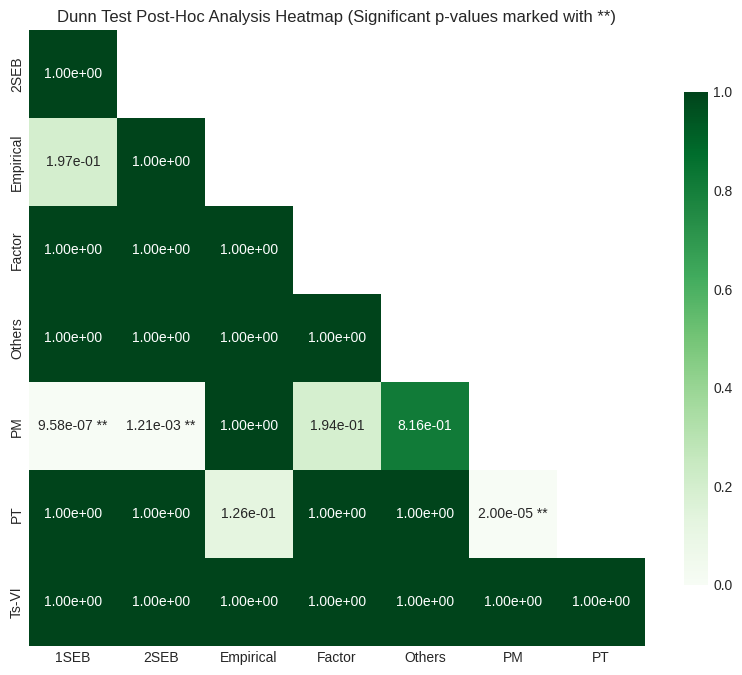

In [53]:
# build an upper‐triangle mask
mask = np.triu(np.ones_like(dunn_results, dtype=bool))

# Create a custom colormap
# Red for p-values < 0.05, shades of green for others
cmap = sns.color_palette("Greens", as_cmap=True)
cmap.set_bad('white') # Set color for masked values

# Create annotations with asterisks for significant values and scientific format
annot_df = dunn_results.copy().astype(str)
for i in range(dunn_results.shape[0]):
    for j in range(dunn_results.shape[1]):
        if pd.notna(dunn_results.iloc[i, j]):
            if dunn_results.iloc[i, j] < 0.05:
                # Format significant p-values in scientific notation with asterisk
                annot_df.iloc[i, j] = f"{dunn_results.iloc[i, j]:.2e} **"
            else:
                # Format non-significant p-values in scientific notation
                annot_df.iloc[i, j] = f"{dunn_results.iloc[i, j]:.2e}"
        else:
            annot_df.iloc[i, j] = ""

# Slice the DataFrame to remove the first row and last column
dunn_results_sliced = dunn_results.iloc[1:, :-1]
annot_df_sliced = annot_df.iloc[1:, :-1]
mask_sliced = mask[1:, :-1]


plt.figure(figsize=(10, 8)) # Increased figure size for potentially larger cells
sns.heatmap(
    dunn_results_sliced,
    mask=mask_sliced,
    annot=annot_df_sliced, # Use the custom annotated dataframe
    cmap=cmap, # Use the custom colormap
    fmt="", # Use empty format as we are formatting in annot_df
    square=True,
    cbar_kws={"shrink": 0.8},
    vmin=0, vmax=1 # Set value range for colormap
)
plt.title('Dunn Test Post-Hoc Analysis Heatmap (Significant p-values marked with **)')
plt.show()

## Plot distribution and Dunn's test

In [54]:
model_order = ['1SEB', '2SEB', 'Empirical', 'Factor', 'PM', 'PT', 'Ts-VI','Others']
dunn_results = dunn_results.reindex(model_order)
dunn_results = dunn_results[model_order]
dunn_results

,1SEB,2SEB,Empirical,Factor,PM,PT,Ts-VI,Others
1SEB,1.000000e+00,1.000000,0.196978,1.00000,9.582505e-07,1.000000,1.0,1.000000
2SEB,1.000000e+00,1.000000,1.000000,1.00000,1.211455e-03,1.000000,1.0,1.000000
Empirical,1.969782e-01,1.000000,1.000000,1.00000,1.000000e+00,0.125541,1.0,1.000000
Factor,1.000000e+00,1.000000,1.000000,1.00000,1.942197e-01,1.000000,1.0,1.000000
PM,9.582505e-07,0.001211,1.000000,0.19422,1.000000e+00,0.000020,1.0,0.816137
PT,1.000000e+00,1.000000,0.125541,1.00000,1.995505e-05,1.000000,1.0,1.000000
Ts-VI,1.000000e+00,1.000000,1.000000,1.00000,1.000000e+00,1.000000,1.0,1.000000
Others,1.000000e+00,1.000000,1.000000,1.00000,8.161370e-01,1.000000,1.0,1.000000


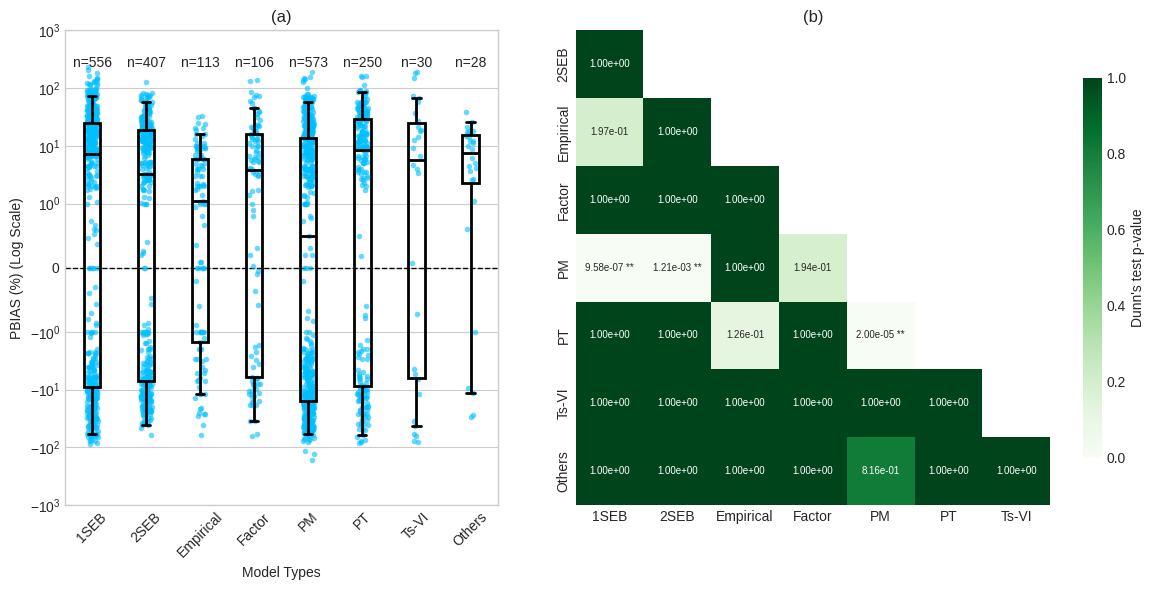

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [2, 3]})

df_ = df_models

# Set up the plot
model_order = ['1SEB', '2SEB', 'Empirical', 'Factor', 'PM', 'PT', 'Ts-VI','Others']
# Plot strip plot first (so it's underneath)
sns.stripplot(x='Model Type', y='PBIAS (%)', ax=axes[0],data=df_,
              color='deepskyblue', jitter=True, size=4, alpha=0.6,order=model_order)

# Overlay boxplot with no fill and thicker, brighter outline
sns.boxplot(
    x='Model Type', y='PBIAS (%)', data=df_,ax=axes[0],
    width=0.3, showcaps=True, showfliers=False,
    boxprops=dict(facecolor='none', edgecolor='black', linewidth=2, zorder=3),
    whiskerprops=dict(color='black', linewidth=2, zorder=3),
    capprops=dict(color='black', linewidth=2, zorder=3),
    medianprops=dict(color='black', linewidth=2, zorder=3)
)

# Annotate group sizes
group_counts = df_['Model Type'].value_counts().reset_index()
group_counts.columns = ['Model Type', 'count']
# Ensure group_counts is in the same order as model_order for correct annotation placement
group_counts = group_counts.set_index('Model Type').loc[model_order].reset_index()


for i, model_type in enumerate(model_order):
    count = group_counts[group_counts['Model Type'] == model_type]['count'].values[0]
    # Adjust text placement slightly if needed based on the log scale
    axes[0].text(i, df_['PBIAS (%)'].max() + 2, f'n={count}', ha='center')


# Labels and title
axes[0].axhline(y=0, color='black', linestyle='--', linewidth=1) # Corrected method here
axes[0].set_xlabel('Model Types')
axes[0].set_ylabel('PBIAS (%) (Log Scale)') # Update y-axis label
axes[0].set_yscale('symlog', linthresh=1) # Set y-axis to symmetric log scale to handle negative values
axes[0].set_ylim(-1000,1000)
axes[0].set_title('(a)') # Add title for the first subplot
axes[0].tick_params(axis='x', rotation=45)

#------------------------------------------------------
# build an upper‐triangle mask
mask = np.triu(np.ones_like(dunn_results, dtype=bool))

# Create a custom colormap
# Red for p-values < 0.05, shades of green for others
cmap = sns.color_palette("Greens", as_cmap=True)
cmap.set_bad('white') # Set color for masked values

# Create annotations with asterisks for significant values and scientific format
annot_df = dunn_results.copy().astype(str)
for i in range(dunn_results.shape[0]):
    for j in range(dunn_results.shape[1]):
        if pd.notna(dunn_results.iloc[i, j]):
            if dunn_results.iloc[i, j] < 0.05:
                # Format significant p-values in scientific notation with asterisk
                annot_df.iloc[i, j] = f"{dunn_results.iloc[i, j]:.2e} **"
            else:
                # Format non-significant p-values in scientific notation
                annot_df.iloc[i, j] = f"{dunn_results.iloc[i, j]:.2e}"
        else:
            annot_df.iloc[i, j] = ""

# Slice the DataFrame to remove the first row and last column
dunn_results_sliced = dunn_results.iloc[1:, :-1]
annot_df_sliced = annot_df.iloc[1:, :-1]
mask_sliced = mask[1:, :-1]

sns.heatmap(
    dunn_results_sliced,
    mask=mask_sliced,
    annot=annot_df_sliced, # Use the custom annotated dataframe
    annot_kws={"fontsize": 7},
    cmap=cmap, # Use the custom colormap
    fmt="", # Use empty format as we are formatting in annot_df
    square=True,
    cbar_kws={"shrink": 0.8,  "label": "Dunn's test p-value"}, # Added orientation and label
    vmin=0, vmax=1, # Set value range for colormap
    ax=axes[1]
)
axes[1].set_title('(b)') # Add title for the second subplot
plt.tight_layout()
plt.savefig(os.path.join(save_folder,'4_pbias_by_model_type.png'), bbox_inches='tight')
plt.show()

## Ranking model

In [56]:
def get_statistical_tiers(pvals_df, alpha=0.05):
    """
    Assigns each group to a single tier (A, B, C, ...) based on pairwise significance.
    Groups that are not significantly different are placed in the same tier.
    """
    groups = list(pvals_df.columns)
    tiers = {}
    assigned = set()
    sorted_groups = pvals_df.replace(np.nan, 1.0).mean().sort_values().index.tolist()
    tier_labels = iter(string.ascii_uppercase)

    for group in sorted_groups:
        if group in assigned:
            continue

        current_tier = next(tier_labels)
        similar = {group}

        for other in sorted_groups:
            if other == group or other in assigned:
                continue
            pval = pvals_df.loc[group, other]
            if pd.isna(pval) or pval >= alpha:
                similar.add(other)

        for g in similar:
            tiers[g] = current_tier
            assigned.add(g)

    return pd.DataFrame({'Model Type': list(tiers.keys()), 'Tier': list(tiers.values())})

dunn_results = sp.posthoc_dunn(df_, val_col='PBIAS (%)', group_col='Model Type', p_adjust='holm')

tier_df = get_statistical_tiers(dunn_results)
tier_df

,Model Type,Tier
0,Empirical,A
1,Others,A
2,Ts-VI,A
3,PM,A
4,Factor,A
5,2SEB,B
6,PT,B
7,1SEB,B


# Model type vs Land cover type

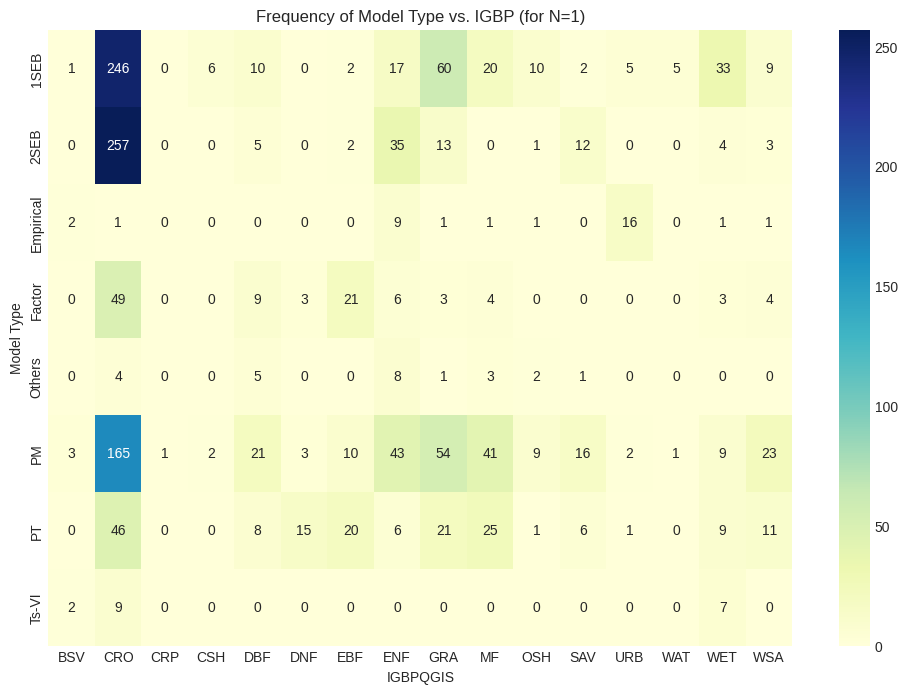

In [57]:
# Filter rows where "Number of sites (N)" is 1
df_ = filtered_df[filtered_df['Number of sites (N)'] == 1]
# Create a cross-tabulation of 'Model Type' and 'IGBPQGIS'
cross_tab = pd.crosstab(df_['Model Type'], df_['IGBP'])

# Plot the frequency of 'Model Type' versus 'IGBPQGIS'
plt.figure(figsize=(12, 8))
sns.heatmap(cross_tab, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Frequency of Model Type vs. IGBP (for N=1)')
plt.xlabel('IGBPQGIS')
plt.ylabel('Model Type')
plt.show()

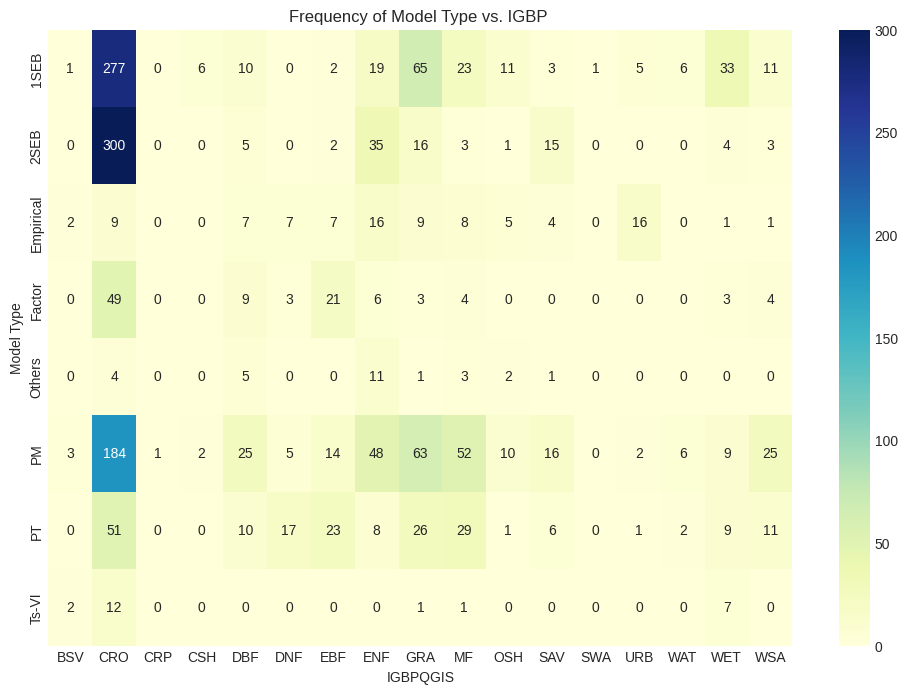

In [58]:
# Filter rows where "Number of sites (N)" is 1
df_ = filtered_df
# Create a cross-tabulation of 'Model Type' and 'IGBPQGIS'
cross_tab = pd.crosstab(df_['Model Type'], df_['IGBP'])

# Plot the frequency of 'Model Type' versus 'IGBPQGIS'
plt.figure(figsize=(12, 8))
sns.heatmap(cross_tab, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Frequency of Model Type vs. IGBP ')
plt.xlabel('IGBPQGIS')
plt.ylabel('Model Type')
plt.show()

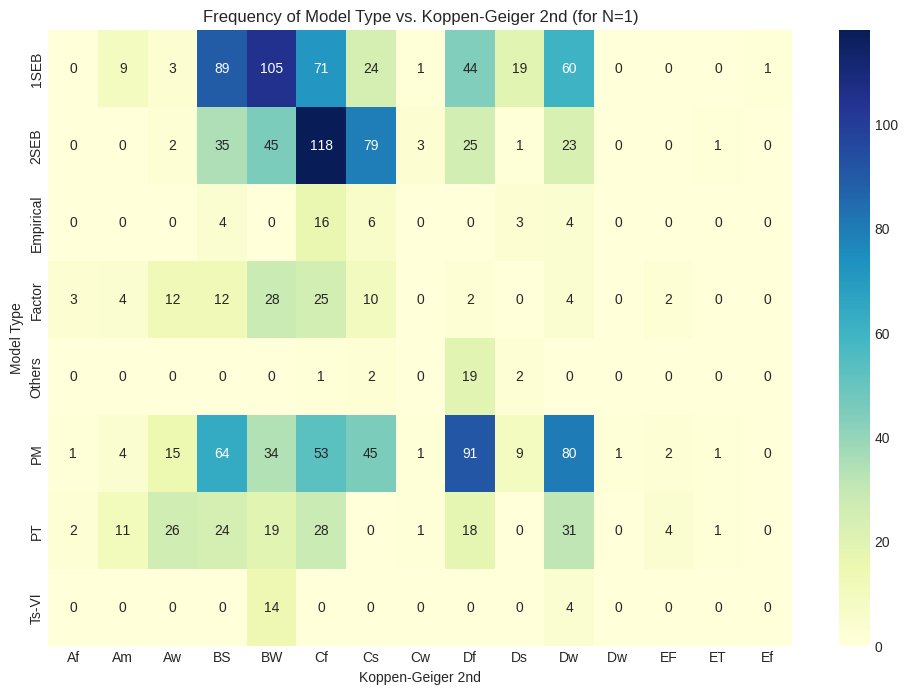

In [59]:
# Filter rows where "Number of sites (N)" is 1
df_ = filtered_df[filtered_df['Number of sites (N)'] == 1]
# Create a cross-tabulation of 'Model Type' and 'IGBPQGIS'
cross_tab = pd.crosstab(df_['Model Type'], df_['Koppen-Geiger 2nd'])

# Plot the frequency of 'Model Type' versus 'IGBPQGIS'
plt.figure(figsize=(12, 8))
sns.heatmap(cross_tab, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Frequency of Model Type vs. Koppen-Geiger 2nd (for N=1)')
plt.xlabel('Koppen-Geiger 2nd')
plt.ylabel('Model Type')
plt.show()

# Model types for only cropland

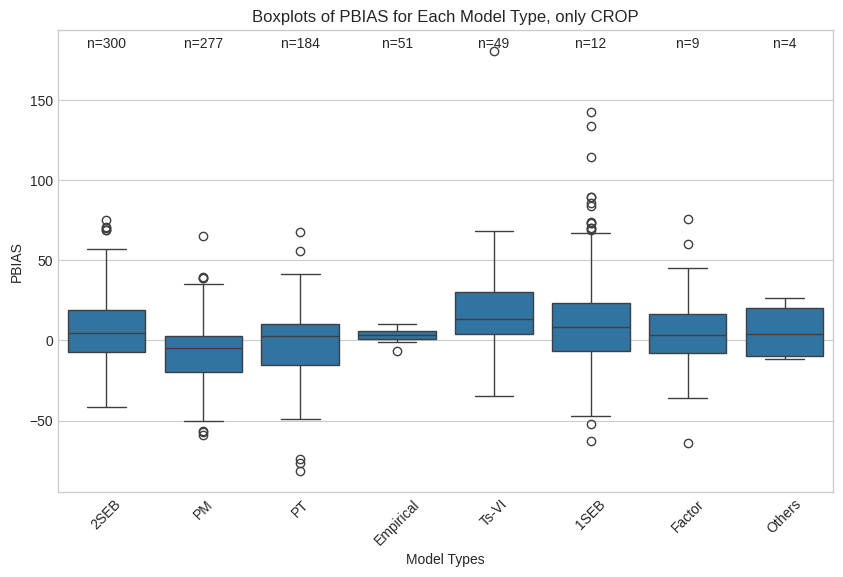

In [60]:
df_ = filtered_df
df_crop = df_[df_['IGBP'] == 'CRO']
# Plot boxplots of PBIAS for each model type
plt.figure(figsize=(10, 6))
sns.boxplot(x='Model Type', y='PBIAS (%)', data=df_crop)

# Annotate the plot with the count of data points for each group
group_counts = df_crop['Model Type'].value_counts().reset_index()
group_counts.columns = ['Model Type', 'count']
for index, row in group_counts.iterrows():
    plt.text(index, df_crop['PBIAS (%)'].max() + 2, f'n={row["count"]}', ha='center')

plt.xlabel('Model Types')
plt.ylabel('PBIAS')
plt.title('Boxplots of PBIAS for Each Model Type, only CROP')
plt.xticks(rotation=45)
plt.show()

## Test difference between the model types

In [61]:
# Perform one-way ANOVA
df_ = df_crop
anova_result = f_oneway(df_[df_['Model Type'] == '2SEB']['PBIAS (%)'],
                        df_[df_['Model Type'] == '1SEB']['PBIAS (%)'],
                        df_[df_['Model Type'] == 'PT']['PBIAS (%)'],
                        df_[df_['Model Type'] == 'PM']['PBIAS (%)'],
                        # df_[df_['Model Type'] == 'Empirical']['PBIAS (%)'],
                        df_[df_['Model Type'] == 'Factor']['PBIAS (%)'],
                        df_[df_['Model Type'] == 'Others']['PBIAS (%)'],
                        )

# Print the ANOVA result
print("ANOVA F-Statistic:", anova_result.statistic)
print("ANOVA p-value:", anova_result.pvalue)

# Check for significance
if anova_result.pvalue < 0.05:
    print("There is a significant difference between the groups (p < 0.05)")
else:
    print("There is no significant difference between the groups (p >= 0.05)")

ANOVA F-Statistic: 14.684692944230028
ANOVA p-value: 7.776977339584389e-14
There is a significant difference between the groups (p < 0.05)


In [62]:
# Perform Kruskal-Wallis H-test
df_ = df_crop
kruskal_result = kruskal(df_[df_['Model Type'] == '2SEB']['PBIAS (%)'],
                        df_[df_['Model Type'] == '1SEB']['PBIAS (%)'],
                        df_[df_['Model Type'] == 'PT']['PBIAS (%)'],
                        df_[df_['Model Type'] == 'PM']['PBIAS (%)'],
                        # df_[df_['Model Type'] == 'Empirical']['PBIAS (%)'],
                        df_[df_['Model Type'] == 'Factor']['PBIAS (%)'],
                        df_[df_['Model Type'] == 'Others']['PBIAS (%)'])


# Print the Kruskal-Wallis test result
print("Kruskal-Wallis H-Statistic:", kruskal_result.statistic)
print("Kruskal-Wallis p-value:", kruskal_result.pvalue)

# Check for significance
if kruskal_result.pvalue < 0.05:
    print("There is a significant difference in the distribution of the groups (p < 0.05)")
else:
    print("There is no significant difference in the distribution of the groups (p >= 0.05)")

Kruskal-Wallis H-Statistic: 69.55228934585183
Kruskal-Wallis p-value: 1.2699670821598865e-13
There is a significant difference in the distribution of the groups (p < 0.05)


## Pair-wise difference test

In [63]:
df_ = df_crop
dunn_results = sp.posthoc_dunn(df_, val_col='PBIAS (%)', group_col='Model Type', p_adjust='holm')
dunn_results


,1SEB,2SEB,Empirical,Factor,Others,PM,PT,Ts-VI
1SEB,1.000000e+00,1.000000e+00,1.0,1.000000,1.0,1.064007e-13,0.212678,1.000000
2SEB,1.000000e+00,1.000000e+00,1.0,1.000000,1.0,2.613200e-10,1.000000,1.000000
Empirical,1.000000e+00,1.000000e+00,1.0,1.000000,1.0,1.000000e+00,1.000000,1.000000
Factor,1.000000e+00,1.000000e+00,1.0,1.000000,1.0,5.519061e-03,1.000000,1.000000
Others,1.000000e+00,1.000000e+00,1.0,1.000000,1.0,1.000000e+00,1.000000,1.000000
PM,1.064007e-13,2.613200e-10,1.0,0.005519,1.0,1.000000e+00,0.632505,0.011789
PT,2.126775e-01,1.000000e+00,1.0,1.000000,1.0,6.325054e-01,1.000000,0.677726
Ts-VI,1.000000e+00,1.000000e+00,1.0,1.000000,1.0,1.178883e-02,0.677726,1.000000


In [64]:
# Assuming a significance level of 0.05, print a summary of Dunn's test results
alpha = 0.05

# Iterate through the columns of the dataframe (which represent the pairwise comparisons)
for column in dunn_results.columns:
    # Iterate through the rows (which also represent the pairwise comparisons)
    for index, p_value in dunn_results[column].items():
        # Get the names of the groups being compared
        group1 = index
        group2 = column

        # Only report comparisons where the p-value is not NaN (i.e., a comparison was performed)
        if pd.notna(p_value):
            # Check if the p-value is less than the significance level
            if p_value < alpha:
                # Print a message indicating a statistically significant difference
                print(f"Dunn's test results: There is a statistically significant difference between group {group1} and group {group2} (p = {p_value:.4f})")
            # else:
            #     # Print a message indicating no statistically significant difference
            #     print(f"Dunn's test results: There is no statistically significant difference between group {group1} and group {group2} (p = {p_value:.4f})")

Dunn's test results: There is a statistically significant difference between group PM and group 1SEB (p = 0.0000)
Dunn's test results: There is a statistically significant difference between group PM and group 2SEB (p = 0.0000)
Dunn's test results: There is a statistically significant difference between group PM and group Factor (p = 0.0055)
Dunn's test results: There is a statistically significant difference between group 1SEB and group PM (p = 0.0000)
Dunn's test results: There is a statistically significant difference between group 2SEB and group PM (p = 0.0000)
Dunn's test results: There is a statistically significant difference between group Factor and group PM (p = 0.0055)
Dunn's test results: There is a statistically significant difference between group Ts-VI and group PM (p = 0.0118)
Dunn's test results: There is a statistically significant difference between group PM and group Ts-VI (p = 0.0118)


## Plot distribution and Dunn's test

In [65]:
model_order = ['1SEB', '2SEB', 'Factor', 'PM', 'PT', 'Ts-VI','Others']
dunn_results = dunn_results.reindex(model_order)
dunn_results = dunn_results[model_order]
dunn_results

,1SEB,2SEB,Factor,PM,PT,Ts-VI,Others
1SEB,1.000000e+00,1.000000e+00,1.000000,1.064007e-13,0.212678,1.000000,1.0
2SEB,1.000000e+00,1.000000e+00,1.000000,2.613200e-10,1.000000,1.000000,1.0
Factor,1.000000e+00,1.000000e+00,1.000000,5.519061e-03,1.000000,1.000000,1.0
PM,1.064007e-13,2.613200e-10,0.005519,1.000000e+00,0.632505,0.011789,1.0
PT,2.126775e-01,1.000000e+00,1.000000,6.325054e-01,1.000000,0.677726,1.0
Ts-VI,1.000000e+00,1.000000e+00,1.000000,1.178883e-02,0.677726,1.000000,1.0
Others,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000,1.000000,1.0


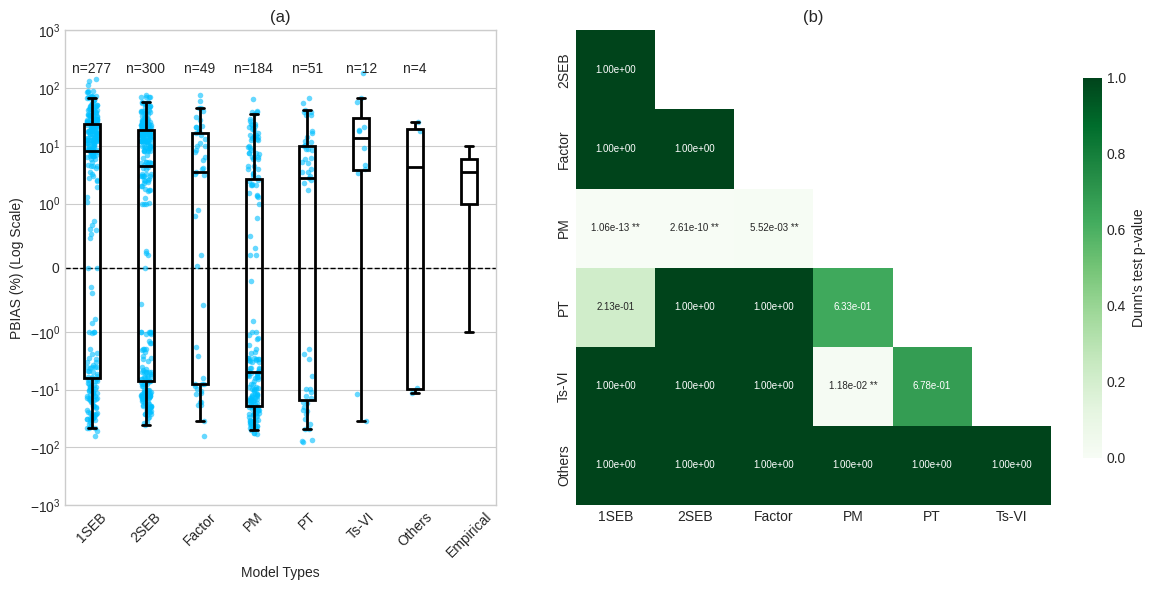

In [66]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [2, 3]})

df_ = df_crop

# Set up the plot
model_order = ['1SEB', '2SEB', 'Factor', 'PM', 'PT', 'Ts-VI','Others']
# Plot strip plot first (so it's underneath)
sns.stripplot(x='Model Type', y='PBIAS (%)', ax=axes[0],data=df_,
              color='deepskyblue', jitter=True, size=4, alpha=0.6,order=model_order)

# Overlay boxplot with no fill and thicker, brighter outline
sns.boxplot(
    x='Model Type', y='PBIAS (%)', data=df_,ax=axes[0],
    width=0.3, showcaps=True, showfliers=False,
    boxprops=dict(facecolor='none', edgecolor='black', linewidth=2, zorder=3),
    whiskerprops=dict(color='black', linewidth=2, zorder=3),
    capprops=dict(color='black', linewidth=2, zorder=3),
    medianprops=dict(color='black', linewidth=2, zorder=3)
)

# Annotate group sizes
group_counts = df_['Model Type'].value_counts().reset_index()
group_counts.columns = ['Model Type', 'count']
# Ensure group_counts is in the same order as model_order for correct annotation placement
group_counts = group_counts.set_index('Model Type').loc[model_order].reset_index()


for i, model_type in enumerate(model_order):
    count = group_counts[group_counts['Model Type'] == model_type]['count'].values[0]
    # Adjust text placement slightly if needed based on the log scale
    axes[0].text(i, df_['PBIAS (%)'].max() + 2, f'n={count}', ha='center')


# Labels and title
axes[0].axhline(y=0, color='black', linestyle='--', linewidth=1) # Corrected method here
axes[0].set_xlabel('Model Types')
axes[0].set_ylabel('PBIAS (%) (Log Scale)') # Update y-axis label
axes[0].set_yscale('symlog', linthresh=1) # Set y-axis to symmetric log scale to handle negative values
axes[0].set_ylim(-1000,1000)
axes[0].set_title('(a)') # Add title for the first subplot
axes[0].tick_params(axis='x', rotation=45)

#------------------------------------------------------
# build an upper‐triangle mask
mask = np.triu(np.ones_like(dunn_results, dtype=bool))

# Create a custom colormap
# Red for p-values < 0.05, shades of green for others
cmap = sns.color_palette("Greens", as_cmap=True)
cmap.set_bad('white') # Set color for masked values

# Create annotations with asterisks for significant values and scientific format
annot_df = dunn_results.copy().astype(str)
for i in range(dunn_results.shape[0]):
    for j in range(dunn_results.shape[1]):
        if pd.notna(dunn_results.iloc[i, j]):
            if dunn_results.iloc[i, j] < 0.05:
                # Format significant p-values in scientific notation with asterisk
                annot_df.iloc[i, j] = f"{dunn_results.iloc[i, j]:.2e} **"
            else:
                # Format non-significant p-values in scientific notation
                annot_df.iloc[i, j] = f"{dunn_results.iloc[i, j]:.2e}"
        else:
            annot_df.iloc[i, j] = ""

# Slice the DataFrame to remove the first row and last column
dunn_results_sliced = dunn_results.iloc[1:, :-1]
annot_df_sliced = annot_df.iloc[1:, :-1]
mask_sliced = mask[1:, :-1]

sns.heatmap(
    dunn_results_sliced,
    mask=mask_sliced,
    annot=annot_df_sliced, # Use the custom annotated dataframe
    annot_kws={"fontsize": 7},
    cmap=cmap, # Use the custom colormap
    fmt="", # Use empty format as we are formatting in annot_df
    square=True,
    cbar_kws={"shrink": 0.8,  "label": "Dunn's test p-value"}, # Added orientation and label
    vmin=0, vmax=1, # Set value range for colormap
    ax=axes[1]
)
axes[1].set_title('(b)') # Add title for the second subplot
plt.tight_layout()
plt.savefig(os.path.join(save_folder,'4_pbias_by_model_type_for_crop.png'), bbox_inches='tight')
plt.show()

# Land cover type

| Code | Description |
|------|-------------|
| BSV  | Barren Sparse Vegetation: Lands exposed soil, sand, or rocks and has less than 10% vegetative cover during any time of the year. |
| CRO  | Croplands: Lands covered with temporary crops followed by harvest and a bare soil period (e.g., single and multiple cropping systems). Note that perennial woody crops will be classified as the appropriate forest or shrub land cover type. |
| CSH  | Closed Shrublands: Lands with woody vegetation less than 2 meters tall and with shrub canopy cover >60%. The shrub foliage can be either evergreen or deciduous. |
| CVM  | Cropland/Natural Vegetation Mosaics: Lands with a mosaic of croplands, forest, shrublands, and grasslands in which no one component comprises more than 60% of the landscape. |
| DBF  | Deciduous Broadleaf Forests: Lands dominated by woody vegetation with a percent cover >60% and height exceeding 2 meters. Consists of broadleaf tree communities with an annual cycle of leaf-on and leaf-off periods. |
| DNF  | Deciduous Needleleaf Forests: Lands dominated by woody vegetation with a percent cover >60% and height exceeding 2 meters. Consists of seasonal needleleaf tree communities with an annual cycle of leaf-on and leaf-off periods. |
| EBF  | Evergreen Broadleaf Forests: Lands dominated by woody vegetation with a percent cover >60% and height exceeding 2 meters. Almost all trees and shrubs remain green year round. Canopy is never without green foliage. |
| ENF  | Evergreen Needleleaf Forests: Lands dominated by woody vegetation with a percent cover >60% and height exceeding 2 meters. Almost all trees remain green all year. Canopy is never without green foliage. |
| GRA  | Grasslands: Lands with herbaceous types of cover. Tree and shrub cover is less than 10%. Permanent wetlands lands with a permanent mixture of water and herbaceous or woody vegetation. The vegetation can be present in either salt, brackish, or fresh water. |
| MF   | Mixed Forests: Lands dominated by trees with a percent cover >60% and height exceeding 2 meters. Consists of tree communities with interspersed mixtures or mosaics of the other four forest types. None of the forest types exceeds 60% of landscape. |
| OSH  | Open Shrublands: Lands with woody vegetation less than 2 meters tall and with shrub canopy cover between 10-60%. The shrub foliage can be either evergreen or deciduous. |
| SAV  | Savannas: Lands with herbaceous and other understory systems, and with forest canopy cover between 10-30%. The forest cover height exceeds 2 meters. |
| SNO  | Snow and Ice: Lands under snow/ice cover most of the year. |
| URB  | Urban and Built-Up Lands: Land covered by buildings and other man-made structures. |
| WAT  | Water Bodies. |
| WET  | Permanent Wetlands: Lands with a permanent mixture of water and herbaceous or woody vegetation that cover extensive areas. The vegetation can be present in either salt, brackish, or fresh water. |
| WSA  | Woody Savannas: Lands with herbaceous and other understory systems, and with forest canopy cover between 30-60%. The forest cover height exceeds 2 meters. |


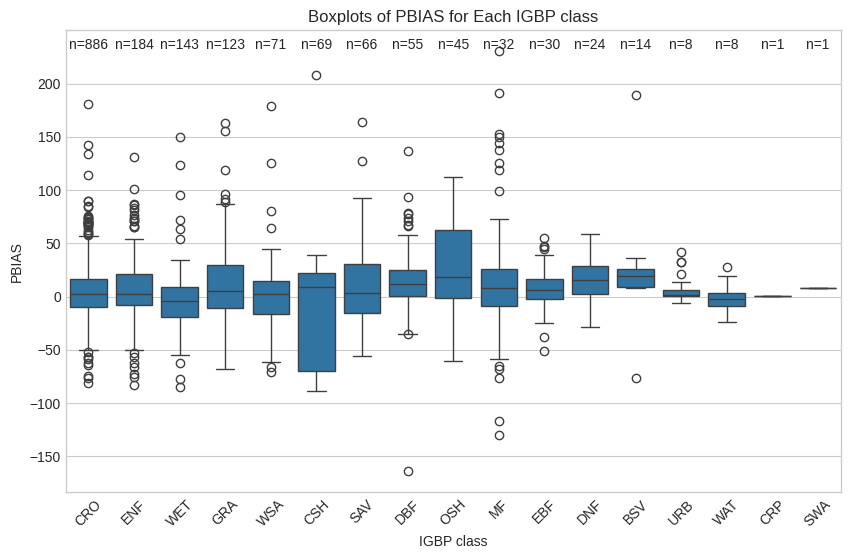

In [67]:
df_ = filtered_df
# Plot boxplots of PBIAS for each model type
plt.figure(figsize=(10, 6))
sns.boxplot(x='IGBP', y='PBIAS (%)', data=df_)

# Annotate the plot with the count of data points for each group
group_counts = df_['IGBP'].value_counts().reset_index()
group_counts.columns = ['IGBP', 'count']
for index, row in group_counts.iterrows():
    plt.text(index, df_['PBIAS (%)'].max() + 2, f'n={row["count"]}', ha='center')

plt.xlabel('IGBP class')
plt.ylabel('PBIAS')
plt.title('Boxplots of PBIAS for Each IGBP class')
plt.xticks(rotation=45)
plt.show()

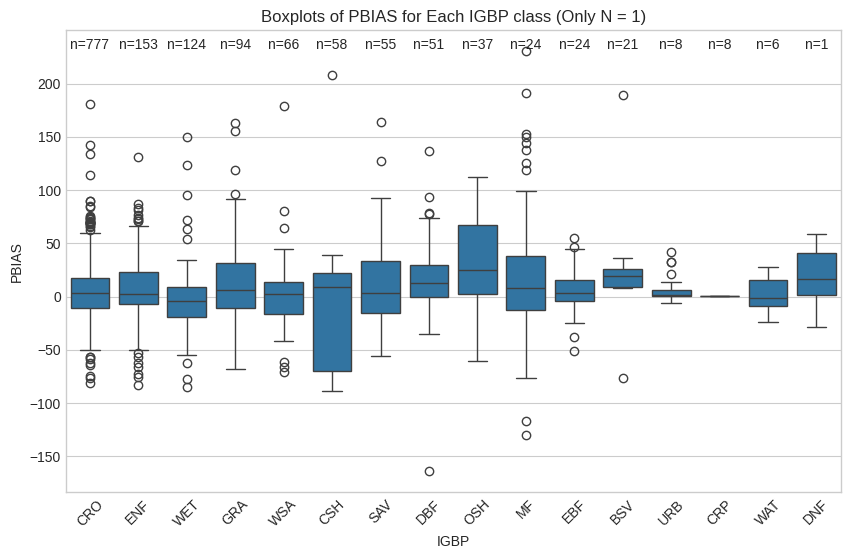

In [68]:
df_ = filtered_df[filtered_df['Number of sites (N)'] == 1]

# Plot boxplots of PBIAS for each model type
plt.figure(figsize=(10, 6))
sns.boxplot(x='IGBP', y='PBIAS (%)', data=df_)

# Annotate the plot with the count of data points for each group
group_counts = df_['IGBP'].value_counts().reset_index()
group_counts.columns = ['IGBP', 'count']
for index, row in group_counts.iterrows():
    plt.text(index, df_['PBIAS (%)'].max() + 2, f'n={row["count"]}', ha='center')

plt.xlabel('IGBP')
plt.ylabel('PBIAS')
plt.title('Boxplots of PBIAS for Each IGBP class (Only N = 1)')
plt.xticks(rotation=45)
plt.show()

In [69]:
# Define a list of values to filter
IGBP_order = ['BSV',
'CRO',
'CSH',
# 'CVM',
'DBF',
'DNF',
'EBF',
'ENF',
'GRA',
'MF',
'OSH',
'SAV',
# 'SNO',
'URB',
'WAT',
'WET',
'WSA'] # valid Model types


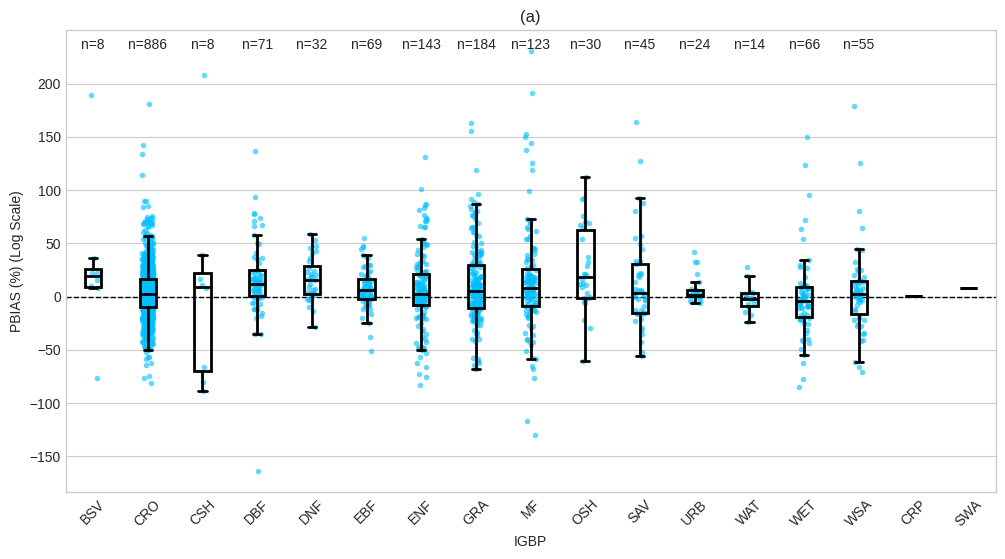

In [70]:
fig, axes = plt.subplots(1, 1, figsize=(12, 6),
                        #  gridspec_kw={'width_ratios': [2, 3]}
                                                            )

df_ = filtered_df

# Set up the plot
# Plot strip plot first (so it's underneath)
sns.stripplot(x='IGBP', y='PBIAS (%)', data=df_,
              # ax=axes[0],
              color='deepskyblue', jitter=True, size=4, alpha=0.6,order=IGBP_order)

# Overlay boxplot with no fill and thicker, brighter outline
sns.boxplot(
    x='IGBP', y='PBIAS (%)', data=df_,
    # ax=axes[0],
    width=0.3, showcaps=True, showfliers=False,
    boxprops=dict(facecolor='none', edgecolor='black', linewidth=2, zorder=3),
    whiskerprops=dict(color='black', linewidth=2, zorder=3),
    capprops=dict(color='black', linewidth=2, zorder=3),
    medianprops=dict(color='black', linewidth=2, zorder=3)
)

# Annotate group sizes
group_counts = df_['IGBP'].value_counts().reset_index()
group_counts.columns = ['IGBP', 'count']
# Ensure group_counts is in the same order as model_order for correct annotation placement
group_counts = group_counts.set_index('IGBP').loc[IGBP_order].reset_index()

axes
for i, model_type in enumerate(IGBP_order):
    count = group_counts[group_counts['IGBP'] == model_type]['count'].values[0]
    # Adjust text placement slightly if needed based on the log scale
    axes.text(i, df_['PBIAS (%)'].max() + 2, f'n={count}', ha='center')


# Labels and title
axes.axhline(y=0, color='black', linestyle='--', linewidth=1) # Corrected method here
axes.set_xlabel('IGBP')
axes.set_ylabel('PBIAS (%) (Log Scale)') # Update y-axis label
# axes.set_yscale('symlog', linthresh=1) # Set y-axis to symmetric log scale to handle negative values
# axes.set_ylim(-1000,1000)
axes.set_title('(a)') # Add title for the first subplot
axes.tick_params(axis='x', rotation=45)


In [71]:
# Group by main land cover class

IGBP_to_LCC = {
'BSV': 'Spare vegetation',
'CRO': 'Cropland',
'CSH': 'Shrubland',
'CVM': 'Cropland',
'DBF': 'Forest',
'DNF': 'Forest',
'EBF': 'Forest',
'ENF': 'Forest',
'GRA': 'Grassland',
'MF': 'Forest',
'OSH': 'Shrubland',
'SAV': 'Savannas',
'SNO': 'Snow and ice',
'URB': 'Builtup',
'WAT': 'Open water',
'WET': 'Wetland',
'WSA': 'Savannas',
}

filtered_df['Land cover'] = filtered_df['IGBP'].map(IGBP_to_LCC)


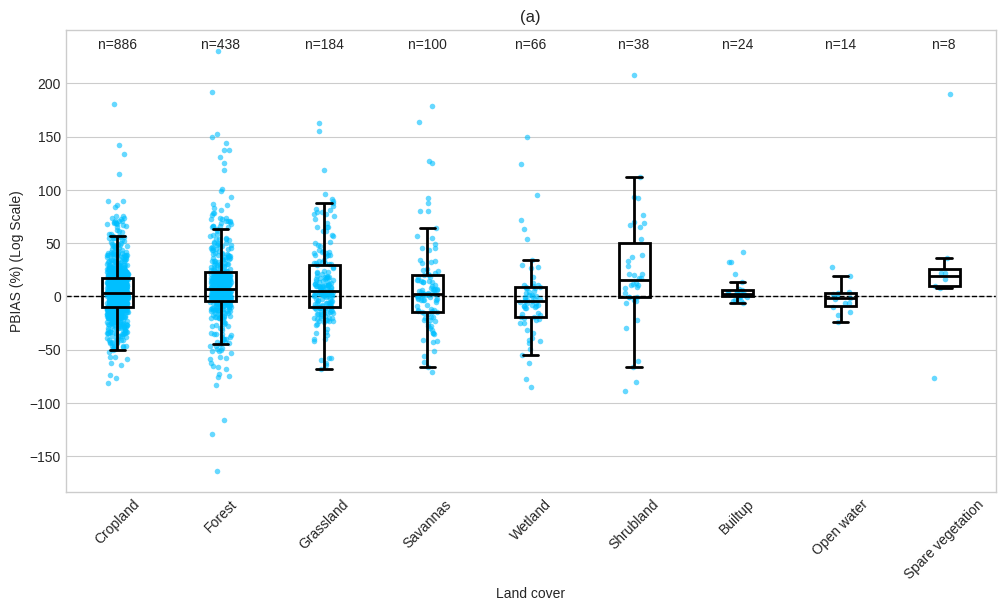

In [72]:
fig, axes = plt.subplots(1, 1, figsize=(12, 6),
                        #  gridspec_kw={'width_ratios': [2, 3]}
                                                            )

df_ = filtered_df

# Sort the groups by count
group_counts = df_['Land cover'].value_counts().reset_index()
group_counts.columns = ['Land cover', 'count']
LCC_order = list(group_counts.sort_values('count', ascending=False)['Land cover'])

# Plot strip plot first (so it's underneath)
sns.stripplot(x='Land cover', y='PBIAS (%)', data=df_,
              # ax=axes[0],
              color='deepskyblue', jitter=True, size=4, alpha=0.6,order=LCC_order)

# Overlay boxplot with no fill and thicker, brighter outline
sns.boxplot(
    x='Land cover', y='PBIAS (%)', data=df_,order=LCC_order,
    # ax=axes[0],
    width=0.3, showcaps=True, showfliers=False,
    boxprops=dict(facecolor='none', edgecolor='black', linewidth=2, zorder=3),
    whiskerprops=dict(color='black', linewidth=2, zorder=3),
    capprops=dict(color='black', linewidth=2, zorder=3),
    medianprops=dict(color='black', linewidth=2, zorder=3)
)

# Ensure group_counts is in the same order as model_order for correct annotation placement
group_counts = group_counts.set_index('Land cover').loc[LCC_order].reset_index()
# Annotate group sizes
for i, model_type in enumerate(LCC_order):
    count = group_counts[group_counts['Land cover'] == model_type]['count'].values[0]
    # Adjust text placement slightly if needed based on the log scale
    axes.text(i, df_['PBIAS (%)'].max() + 2, f'n={count}', ha='center')


# Labels and title
axes.axhline(y=0, color='black', linestyle='--', linewidth=1) # Corrected method here
axes.set_xlabel('Land cover')
axes.set_ylabel('PBIAS (%) (Log Scale)') # Update y-axis label
# axes.set_yscale('symlog', linthresh=1) # Set y-axis to symmetric log scale to handle negative values
# axes.set_ylim(-1000,1000)
axes.set_title('(a)') # Add title for the first subplot
axes.tick_params(axis='x', rotation=45)


In [73]:
df_ = filtered_df
# Perform Kruskal-Wallis H-test
kruskal_result = kruskal(df_[df_['Land cover'] == 'Cropland']['PBIAS (%)'],
                        df_[df_['Land cover'] == 'Forest']['PBIAS (%)'],
                        df_[df_['Land cover'] == 'Grassland']['PBIAS (%)'],
                        df_[df_['Land cover'] == 'Savannas']['PBIAS (%)'],
                        # remove the below because the sample size is too small to compare with other classes
                        # df_[df_['Land cover'] == 'Welands']['PBIAS (%)'],
                        # df_[df_['Land cover'] == 'Shrubland']['PBIAS (%)'],
                        # df_[df_['Land cover'] == 'Builtup']['PBIAS (%)'],
                        #  df_[df_['Land cover'] == 'Open water']['PBIAS (%)'],
                         )


# Print the Kruskal-Wallis test result
print("Kruskal-Wallis H-Statistic:", kruskal_result.statistic)
print("Kruskal-Wallis p-value:", kruskal_result.pvalue)

# Check for significance
if kruskal_result.pvalue < 0.05:
    print("There is a significant difference in the distribution of the groups (p < 0.05)")
else:
    print("There is no significant difference in the distribution of the groups (p >= 0.05)")

Kruskal-Wallis H-Statistic: 15.614519413052312
Kruskal-Wallis p-value: 0.0013601477069999175
There is a significant difference in the distribution of the groups (p < 0.05)


## Land cover types for only PM models

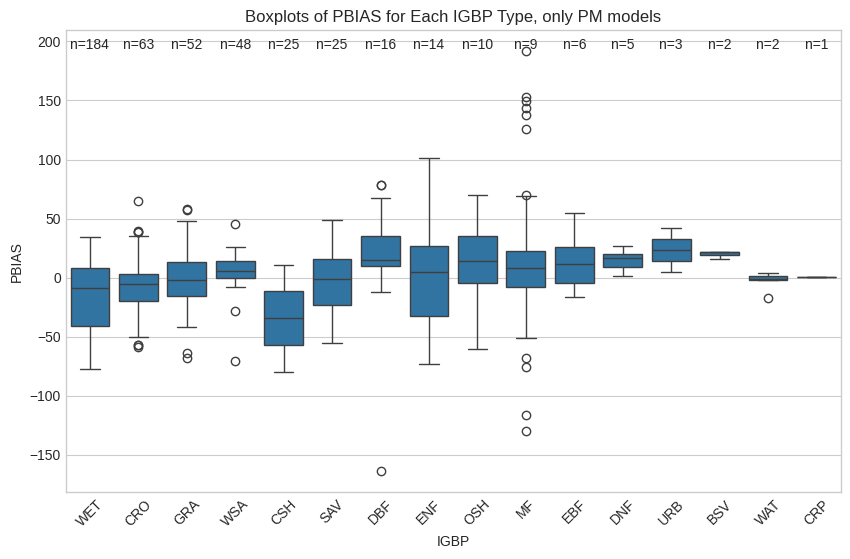

In [75]:
df_PM = filtered_df[filtered_df['Model Type'] == 'PM']
df_ = df_PM
# Plot boxplots of PBIAS for each model type
plt.figure(figsize=(10, 6))
sns.boxplot(x='IGBP', y='PBIAS (%)', data=df_)

# Annotate the plot with the count of data points for each group
group_counts = df_['IGBP'].value_counts().reset_index()
group_counts.columns = ['IGBP', 'count']
for index, row in group_counts.iterrows():
    plt.text(index, df_['PBIAS (%)'].max() + 2, f'n={row["count"]}', ha='center')

plt.xlabel('IGBP')
plt.ylabel('PBIAS')
plt.title('Boxplots of PBIAS for Each IGBP Type, only PM models')
plt.xticks(rotation=45)
plt.show()

# Climate

![Climate type map](https://upload.wikimedia.org/wikipedia/commons/thumb/c/cd/Koppen-Geiger_Map_v2_World_1991%E2%80%932020.svg/960px-Koppen-Geiger_Map_v2_World_1991%E2%80%932020.svg.png)

| 1st           | 2nd                                 | 3rd                         |
|---------------|-------------------------------------|-----------------------------|
| A (Tropical)  | f (Rainforest)                      |                             |
|               | m (Monsoon)                         |                             |
|               | w (Savanna, dry winter)             |                             |
|               | s (Savanna, dry summer)             |                             |
| B (Dry)       | W (Arid desert)                     | h (Hot)                     |
|               | S (Semi-arid steppe)                | k (Cold)                    |
| C (Temperate) | w (Dry winter)                      | a (Hot summer)              |
|               | f (No dry season)                   | b (Warm summer)             |
|               | s (Dry summer)                      | c (Cold summer)             |
| D (Continental)| w (Dry winter)                     | a (Hot summer)              |
|               | f (No dry season)                   | b (Warm summer)             |
|               | s (Dry summer)                      | c (Cold summer)             |
|               |                                     | d (Very cold winter)        |
| E (Polar)     | T (Tundra)                          |                             |
|               | F (Ice cap)                         |                             |


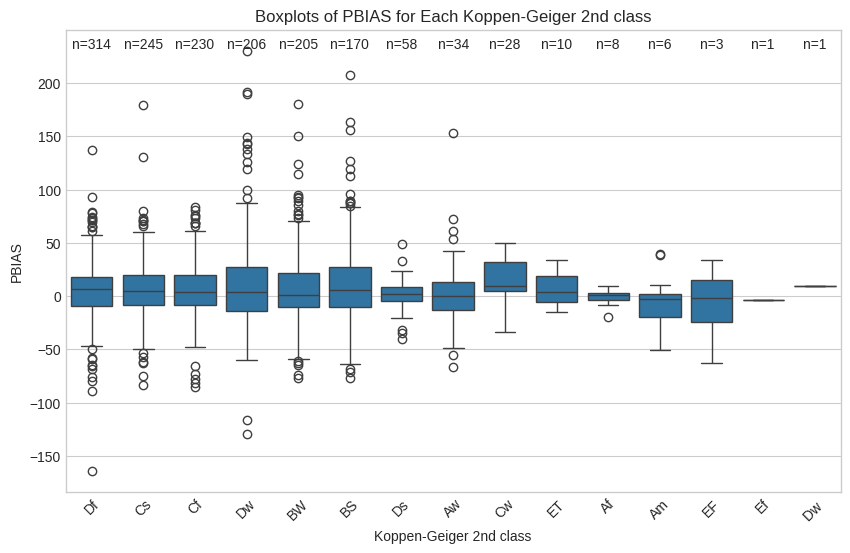

In [76]:
df_ = filtered_df
# Plot boxplots of PBIAS for each model type
plt.figure(figsize=(10, 6))
sns.boxplot(x='Koppen-Geiger 2nd', y='PBIAS (%)', data=df_)

# Annotate the plot with the count of data points for each group
group_counts = df_['Koppen-Geiger 2nd'].value_counts().reset_index()
group_counts.columns = ['Koppen-Geiger 2nd', 'count']
for index, row in group_counts.iterrows():
    plt.text(index, df_['PBIAS (%)'].max() + 2, f'n={row["count"]}', ha='center')

plt.xlabel('Koppen-Geiger 2nd class')
plt.ylabel('PBIAS')
plt.title('Boxplots of PBIAS for Each Koppen-Geiger 2nd class')
plt.xticks(rotation=45)
plt.show()

## Climate types for only PM models

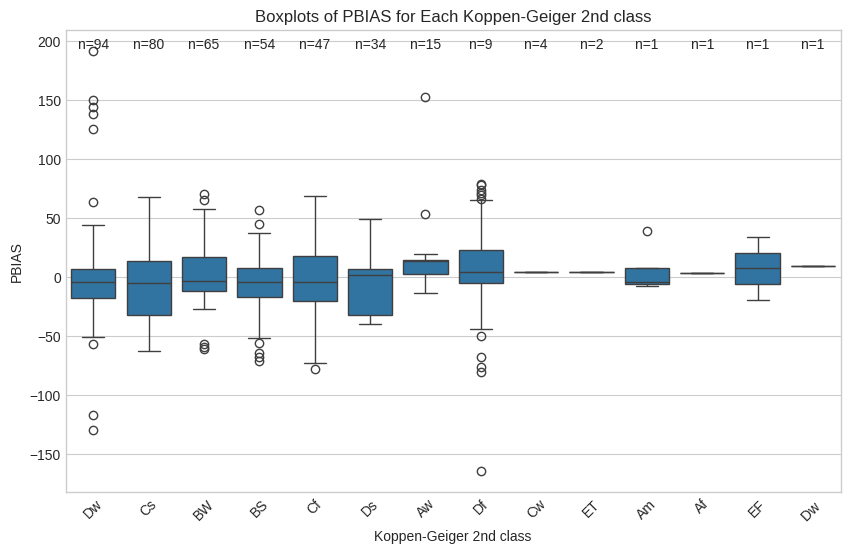

In [77]:
df_ = df_PM
# Plot boxplots of PBIAS for each model type
plt.figure(figsize=(10, 6))
sns.boxplot(x='Koppen-Geiger 2nd', y='PBIAS (%)', data=df_)

# Annotate the plot with the count of data points for each group
group_counts = df_['Koppen-Geiger 2nd'].value_counts().reset_index()
group_counts.columns = ['Koppen-Geiger 2nd', 'count']
for index, row in group_counts.iterrows():
    plt.text(index, df_['PBIAS (%)'].max() + 2, f'n={row["count"]}', ha='center')

plt.xlabel('Koppen-Geiger 2nd class')
plt.ylabel('PBIAS')
plt.title('Boxplots of PBIAS for Each Koppen-Geiger 2nd class')
plt.xticks(rotation=45)
plt.show()

# Elevation

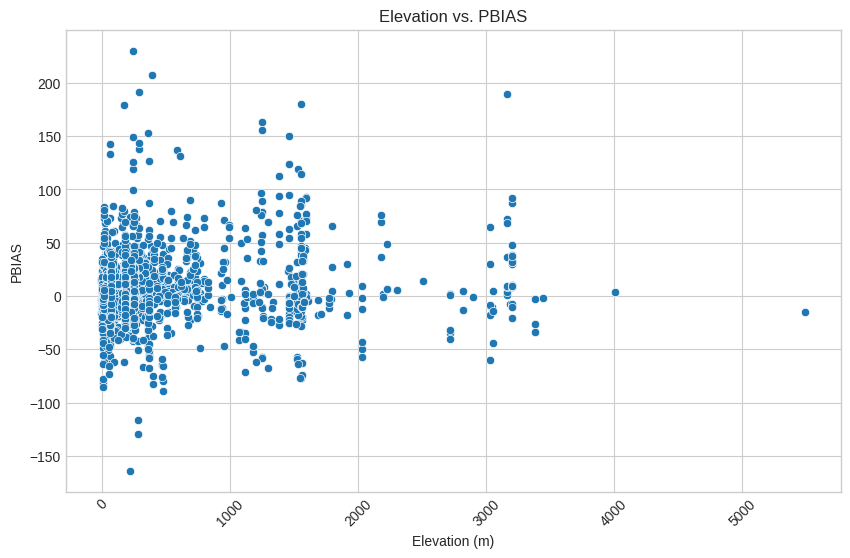

In [78]:
df_ = filtered_df[['Elevation (m)','PBIAS (%)']]
# Plot boxplots of PBIAS for each model type
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Elevation (m)', y='PBIAS (%)', data=df_)

plt.xlabel('Elevation (m)')
plt.ylabel('PBIAS')
plt.title('Elevation vs. PBIAS')
plt.xticks(rotation=45)
plt.show()

## Elevation for only PM models

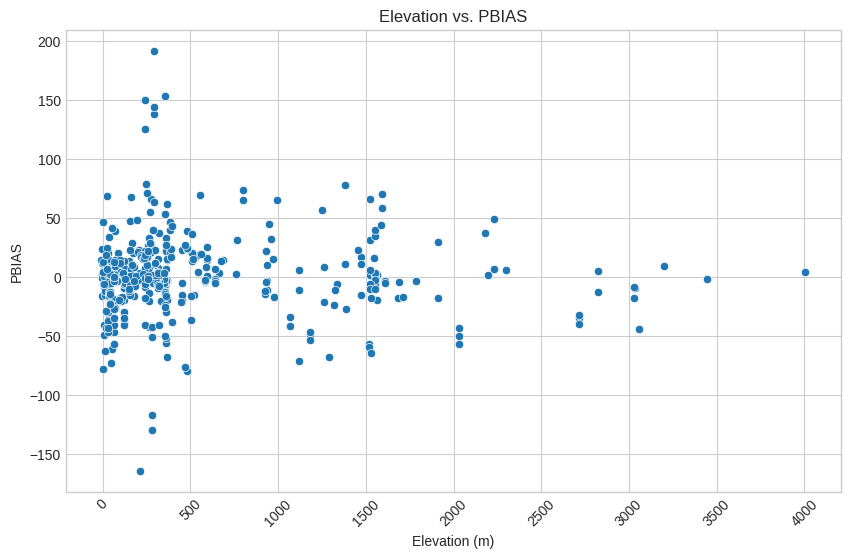

In [79]:
df_ = df_PM[['Elevation (m)','PBIAS (%)']]
# Plot boxplots of PBIAS for each model type
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Elevation (m)', y='PBIAS (%)', data=df_)

plt.xlabel('Elevation (m)')
plt.ylabel('PBIAS')
plt.title('Elevation vs. PBIAS')
plt.xticks(rotation=45)
plt.show()

# Products vs Models

/tmp/ipython-input-992987426.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




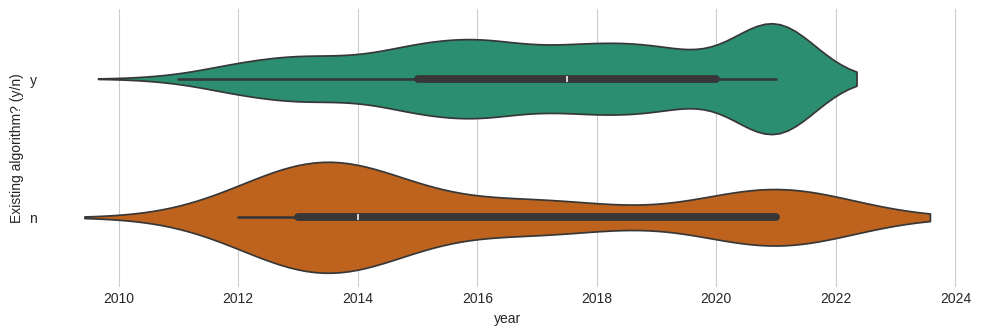

In [80]:
figsize = (12, 1.2 * len(df['Existing algorithm? (y/n)'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='year', y='Existing algorithm? (y/n)', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

/tmp/ipython-input-1672482316.py:18: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



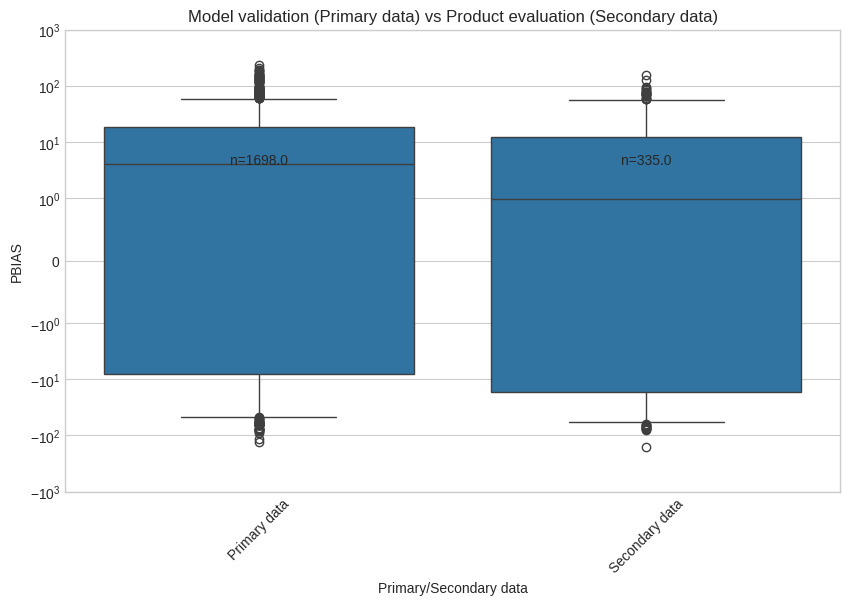

In [81]:
df_ = filtered_df
# Plot boxplots of PBIAS for each model type
plt.figure(figsize=(10, 6))
boxplot=sns.boxplot(x='Primary/Secondary data', y='PBIAS (%)', data=df_)

# Annotate the plot with the count of data points for each group
group_counts = df_['Primary/Secondary data'].value_counts().reset_index()
group_counts.columns = ['Primary/Secondary data', 'count']
for index, row in group_counts.iterrows():
    plt.text(index, df_['Primary/Secondary data'].max() + 2, f'n={row["count"]}', ha='center')

plt.xlabel('Primary/Secondary data')
plt.ylabel('PBIAS')
plt.yscale('symlog', linthresh=1)
plt.ylim(-1000,1000)
plt.title('Model validation (Primary data) vs Product evaluation (Secondary data)')
plt.xticks(rotation=45)
boxplot.set_xticklabels(['Primary data','Secondary data'])
plt.show()

In [82]:
df_['PBIAS (%)'] = pd.to_numeric(df_['PBIAS (%)'], errors='coerce')
# Separate data into "Primary" and "Secondary" groups
primary_data = df_[df_['Primary/Secondary data'] == 1]['PBIAS (%)']
secondary_data = df_[df_['Primary/Secondary data'] == 2]['PBIAS (%)']

# Perform independent t-test
t_statistic, p_value = ttest_ind(primary_data, secondary_data)

# Print the results
print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

# Check for significance
if p_value < 0.05:
    print("The difference between the groups is statistically significant (p < 0.05)")
else:
    print("The difference between the groups is not statistically significant (p >= 0.05)")

T-Statistic: 4.49871223832035
P-Value: 7.2228568858942255e-06
The difference between the groups is statistically significant (p < 0.05)


In [83]:
df_test = df_[['Primary/Secondary data','PBIAS (%)']]
df_test

,Primary/Secondary data,PBIAS (%)
0,1.0,13.100000
1,1.0,8.000000
2,1.0,19.400000
3,1.0,14.600000
4,1.0,8.200000
...,...,...
2065,1.0,-3.200000
2066,1.0,0.400000
2067,1.0,5.200001
2068,1.0,80.999988


In [84]:
# Group the data by 'Primary/Secondary data'
grouped_data = df_test.groupby('Primary/Secondary data')

# Iterate over each group
for name, group in grouped_data:
    # Perform the Shapiro-Wilk test for normality on the 'PBIAS (%)' column
    statistic, p_value = stats.shapiro(group['PBIAS (%)'])

    # Print the results for each group
    print(f"Results for group: {name}")
    print(f"Shapiro-Wilk Test Statistic: {statistic:.4f}")
    print(f"P-value: {p_value:.4f}")

    # Interpret the results
    alpha = 0.05
    if p_value > alpha:
        print(f"For group {name}, the data appears to be normally distributed (p > {alpha}).")
    else:
        print(f"For group {name}, the data does not appear to be normally distributed (p <= {alpha}).")
    print("-" * 30)


Results for group: 1.0
Shapiro-Wilk Test Statistic: 0.8743
P-value: 0.0000
For group 1.0, the data does not appear to be normally distributed (p <= 0.05).
------------------------------
Results for group: 2.0
Shapiro-Wilk Test Statistic: 0.9551
P-value: 0.0000
For group 2.0, the data does not appear to be normally distributed (p <= 0.05).
------------------------------


In [85]:
# Separate the data into two groups based on the 'Primary/Secondary data' column
group1 = df_test[df_test['Primary/Secondary data'] == 1]['PBIAS (%)']
group2 = df_test[df_test['Primary/Secondary data'] == 2]['PBIAS (%)']
# Perform the Mann-Whitney U test
statistic, p_value = mannwhitneyu(group1, group2)
# Print the results and explanation
print(f"Mann-Whitney U Statistic: {statistic}")
print(f"P-value: {p_value}")
if p_value < 0.05:
    print("The p-value is less than 0.05, indicating a statistically significant difference in 'PBIAS (%)' between the two groups.")
else:
    print("The p-value is greater than or equal to 0.05, indicating no statistically significant difference in 'PBIAS (%)' between the two groups.")

Mann-Whitney U Statistic: 324936.0
P-value: 3.680479894080407e-05
The p-value is less than 0.05, indicating a statistically significant difference in 'PBIAS (%)' between the two groups.


In [86]:
# Using dataframe df_test: calculate descriptive statistics of 'PBIAS (%)' for each group in 'Primary/Secondary data'.

df_test.groupby('Primary/Secondary data')['PBIAS (%)'].describe()

,count,mean,std,min,25%,50%,75%,max
Primary/Secondary data,,,,,,,,
1.0,1698.0,8.188399,32.587972,-129.470164,-8.000000,3.993355,18.643512,230.279898
2.0,335.0,-0.670026,34.659086,-164.000000,-17.115732,0.990000,12.454841,152.900000


/tmp/ipython-input-2282739593.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




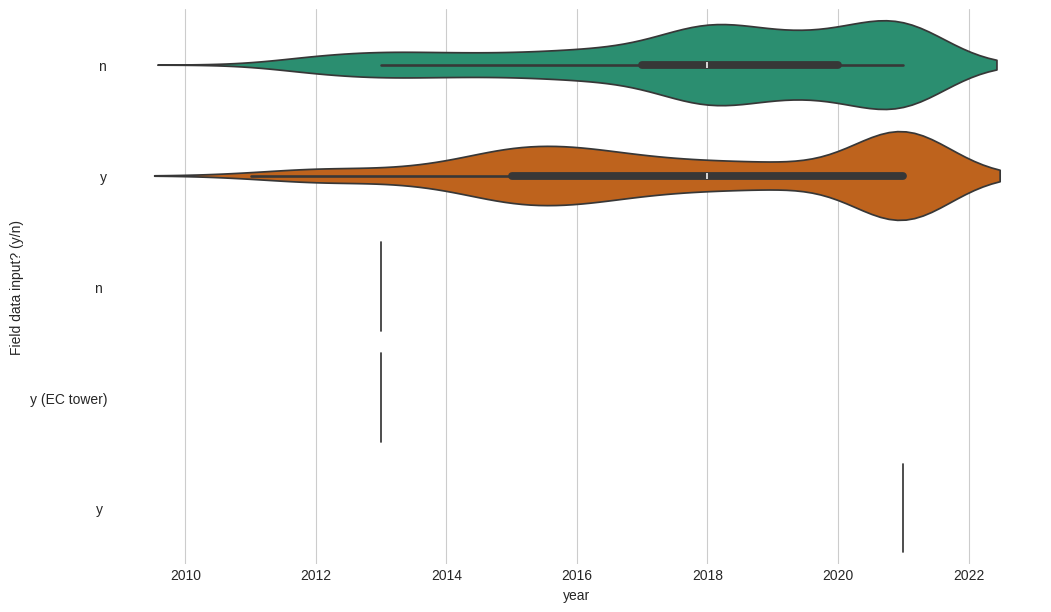

In [87]:
figsize = (12, 1.2 * len(df['Field data input? (y/n)'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='year', y='Field data input? (y/n)', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

# EC correction methods

In [88]:
df_EC = df_numeric_pBIAS[['record_id','PBIAS (%)', 'EB correction','use for EB comparison' ]] #using un-filtered to keep outliers
df_EC_all = filtered_df[['record_id','PBIAS (%)', 'EB correction']]

df_EC = df_EC.dropna()
df_EC_all = df_EC_all.dropna()

In [89]:
# Number of studies
print('Number of studies: {0}'.format(len(df_EC['record_id'].unique())))
df_EC['EB correction'].unique()

Number of studies: 10


array([1., 2., 3., 4.])

In [90]:
# Number of studies
print('Number of studies: {0}'.format(len(df_EC_all['record_id'].unique())))
df_EC_all['EB correction'].unique()

Number of studies: 63


array([3., 1., 2., 4.])

## Plot statstics of all studies that mentioned EBC treatment

In [91]:
df_EC_all.groupby('EB correction')['PBIAS (%)'].describe()

,count,mean,std,min,25%,50%,75%,max
EB correction,,,,,,,,
1.0,324.0,10.375509,42.091781,-129.470164,-12.004569,4.000000,18.558696,230.279898
2.0,284.0,1.911678,27.561417,-76.626826,-14.181965,-1.000000,19.000000,148.600000
3.0,360.0,5.939317,30.947164,-82.583708,-6.306938,3.494090,18.560495,180.492308
4.0,28.0,9.916633,11.176467,-11.449184,3.643993,8.371891,15.385874,36.756757


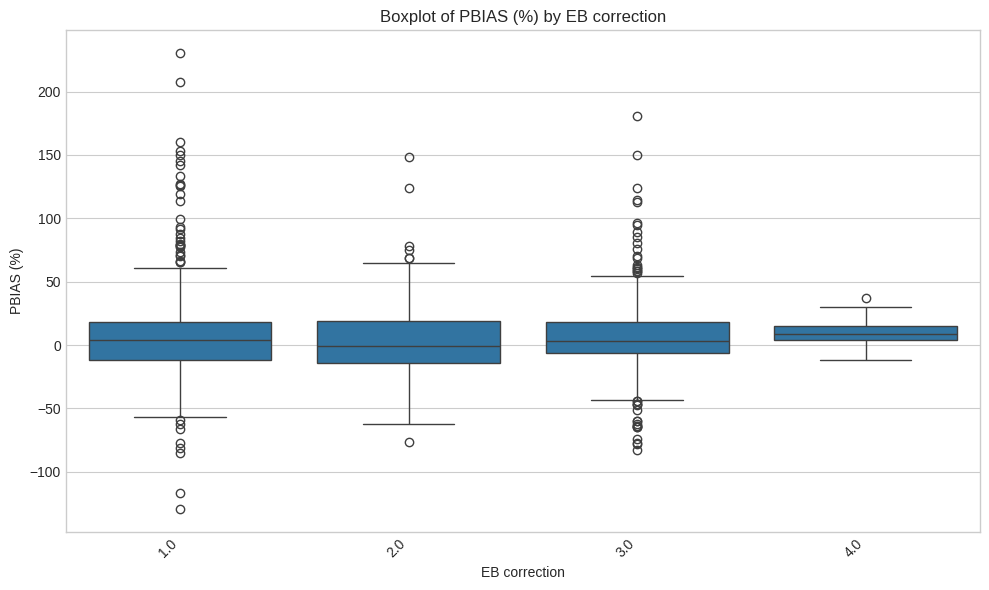

In [92]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='EB correction', y='PBIAS (%)', data=df_EC_all)
plt.xlabel('EB correction')
plt.ylabel('PBIAS (%)')
plt.title('Boxplot of PBIAS (%) by EB correction')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
# plt.yscale('symlog', linthresh=1)
# plt.ylim(-1000,1000)
plt.show()

In [93]:
df_ = df_EC_all
# Perform Kruskal-Wallis H-test
kruskal_result = kruskal(df_[df_['EB correction'] == 1]['PBIAS (%)'],
                        df_[df_['EB correction'] == 2]['PBIAS (%)'],
                           df_[df_['EB correction'] == 3]['PBIAS (%)'],
                            df_[df_['EB correction'] == 4]['PBIAS (%)'],
                         )


# Print the Kruskal-Wallis test result
print("Kruskal-Wallis H-Statistic:", kruskal_result.statistic)
print("Kruskal-Wallis p-value:", kruskal_result.pvalue)

# Check for significance
if kruskal_result.pvalue < 0.05:
    print("There is a significant difference in the distribution of the groups (p < 0.05)")
else:
    print("There is no significant difference in the distribution of the groups (p >= 0.05)")

Kruskal-Wallis H-Statistic: 8.970496561553226
Kruskal-Wallis p-value: 0.029685733568193227
There is a significant difference in the distribution of the groups (p < 0.05)


In [94]:
dunn_results = sp.posthoc_dunn(df_, val_col='PBIAS (%)', group_col='EB correction', p_adjust='holm')
dunn_results

,1.0,2.0,3.0,4.0
1.0,1.000000,0.163185,0.983601,0.414202
2.0,0.163185,1.000000,0.163185,0.120444
3.0,0.983601,0.163185,1.000000,0.414202
4.0,0.414202,0.120444,0.414202,1.000000


 a significant Kruskal-Wallis test indicates that there's some difference among the groups, but a non-significant Dunn's test suggests that none of the individual pairwise comparisons are strong enough to be declared statistically significant after accounting for multiple comparisons. It highlights that while the groups are not all the same, the specific differences between pairs of groups might be subtle or require more data to be confidently identified.

## Studies that applied more than one treatment of EBC

In [95]:
df_EC_stats= df_EC.groupby('EB correction')['PBIAS (%)'].describe()
df_EC_stats

,count,mean,std,min,25%,50%,75%,max
EB correction,,,,,,,,
1.0,63.0,54.051771,71.978430,-129.470164,15.900000,41.166831,85.972916,277.983764
2.0,53.0,-10.295395,38.901159,-58.128079,-33.938290,-18.200000,-4.562156,148.600000
3.0,44.0,3.864625,25.901979,-51.090621,-11.939450,7.331588,19.179025,61.194030
4.0,10.0,17.702948,10.233711,6.250000,8.699634,16.773459,23.370133,36.756757


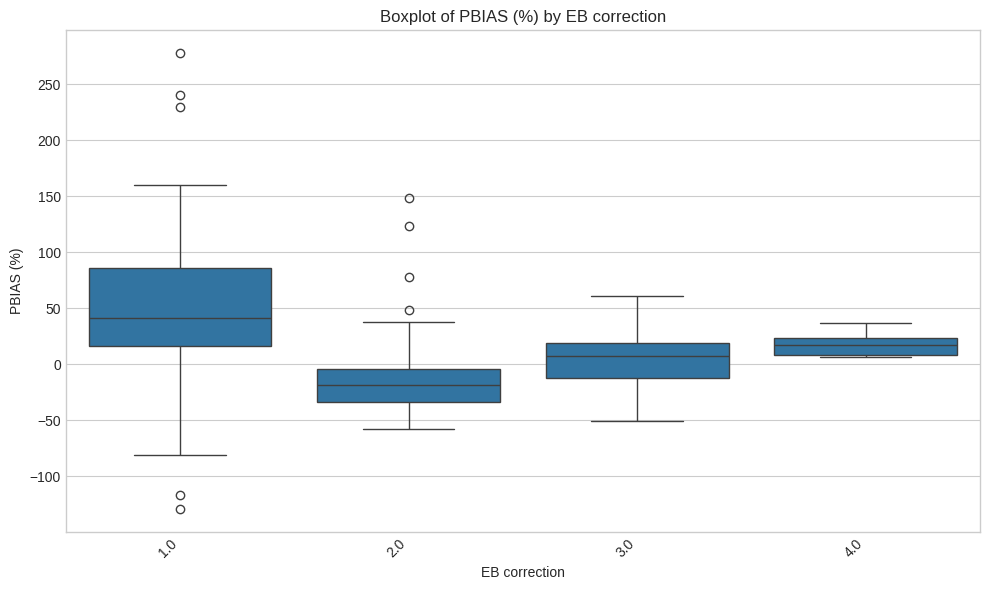

In [96]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='EB correction', y='PBIAS (%)', data=df_EC)
plt.xlabel('EB correction')
plt.ylabel('PBIAS (%)')
plt.title('Boxplot of PBIAS (%) by EB correction')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
# plt.yscale('symlog', linthresh=1)
# plt.ylim(-1000,1000)
plt.show()

In [97]:
df_ = df_EC
# Perform Kruskal-Wallis H-test
kruskal_result = kruskal(df_[df_['EB correction'] == 1]['PBIAS (%)'],
                        df_[df_['EB correction'] == 2]['PBIAS (%)'],
                           df_[df_['EB correction'] == 3]['PBIAS (%)'],
                            df_[df_['EB correction'] == 4]['PBIAS (%)'],
                         )


# Print the Kruskal-Wallis test result
print("Kruskal-Wallis H-Statistic:", kruskal_result.statistic)
print("Kruskal-Wallis p-value:", kruskal_result.pvalue)

# Check for significance
if kruskal_result.pvalue < 0.05:
    print("There is a significant difference in the distribution of the groups (p < 0.05)")
else:
    print("There is no significant difference in the distribution of the groups (p >= 0.05)")

Kruskal-Wallis H-Statistic: 58.30066947413048
Kruskal-Wallis p-value: 1.3558564085303356e-12
There is a significant difference in the distribution of the groups (p < 0.05)


In [98]:
dunn_results = sp.posthoc_dunn(df_, val_col='PBIAS (%)', group_col='EB correction', p_adjust='holm')
dunn_results

,1.0,2.0,3.0,4.0
1.0,1.000000e+00,4.665422e-13,0.000059,0.377424
2.0,4.665422e-13,1.000000e+00,0.027140,0.015924
3.0,5.908688e-05,2.714007e-02,1.000000,0.377424
4.0,3.774235e-01,1.592352e-02,0.377424,1.000000


In [99]:
grouped_data = df_EC.groupby(['record_id', 'EB correction'])

# Calculate descriptive statistics for 'PBIAS (%)' for each group
grouped_pbias_stats = grouped_data['PBIAS (%)'].describe()
display(grouped_pbias_stats)

count        mean        std         min         25%  \
record_id EB correction                                                         
101127    1.0             10.0   91.485126  27.362409   50.684932   79.166667   
          2.0             10.0  -29.821573  17.737725  -58.128079  -36.209440   
          3.0             10.0    7.143134  15.404253  -11.458333   -5.178590   
          4.0             10.0   17.702948  10.233711    6.250000    8.699634   
101316    1.0              2.0   -4.533078   2.189207   -6.081081   -5.307079   
          3.0              2.0   -0.238152   0.623076   -0.678733   -0.458442   
101390    1.0             12.0  106.352513  97.494914    2.448980   33.745917   
          2.0             12.0  -33.482440  14.016825  -56.783874  -42.615020   
          3.0             12.0   -9.403685  22.872115  -46.345487  -30.986576   
101624    1.0              4.0  -88.491157  46.014382 -129.470164 -119.727767   
          3.0              4.0  -24.238849  30.186717  -51.090621  -44.675910   
102268    1.0              8.0   45.703576  21.191471   15.067079   34.057908   
          3.0              8.0   24.381505  10.298067   15.769231   18.114537   
102448    2.0              4.0   -3.479920  17.988941  -23.076923  -16.590126   
          3.0              4.0   37.839681  27.256905    7.594937   18.388096   
102849    1.0              3.0   26.743614   6.415013   20.413437   23.495309   
          2.0              3.0   -1.452432   3.216558   -4.618474   -3.084832   
103486    1.0              4.0   58.007319  50.294262   12.539683   24.223356   
          2.0              4.0  -29.388650   9.652483  -39.659106  -35.815054   
          3.0              4.0   -9.380675  19.616494  -26.777811  -19.176011   
103789    1.0             16.0   46.087500  57.842417  -17.900000   12.650000   
          2.0             16.0   21.412500  53.828454  -34.200000  -12.000000   
200384    1.0              4.0   40.480550  31.505353    6.653556   25.449229   
          2.0              4.0  -13.104832  15.323425  -31.077771  -22.677800   

                               50%         75%         max  
record_id EB correction                                     
101127    1.0            85.972916   92.524531  142.391304  
          2.0           -27.758621  -15.979381   -7.951070  
          3.0             6.593792   11.226536   33.185841  
          4.0            16.773459   23.370133   36.756757  
101316    1.0            -4.533078   -3.759076   -2.985075  
          3.0            -0.238152   -0.017861    0.202429  
101390    1.0            70.502793  169.814872  277.983764  
          2.0           -37.197433  -21.859011   -8.706468  
          3.0            -6.995682    7.457739   22.333333  
101624    1.0           -98.986852  -67.750241  -26.520760  
          3.0           -31.173655  -10.736594   16.482536  
102268    1.0            48.933022   58.539805   70.952381  
          3.0            19.989030   27.248597   40.813253  
102448    2.0            -1.543827   11.566379   12.244898  
          3.0            41.284879   60.736464   61.194030  
102849    1.0            26.577181   29.908702   33.240223  
          2.0            -1.551189    0.130589    1.812367  
103486    1.0            46.949812   80.733776  125.589971  
          2.0           -30.002638  -23.576234  -17.890216  
          3.0           -14.712891   -4.917556   18.680892  
103789    1.0            24.250000   68.200000  160.200000  
          2.0            -3.150000   40.175000  148.600000  
200384    1.0            36.440642   51.471963   82.387361  
          2.0           -12.219982   -2.647015    3.098407

In [100]:
grouped_pbias_stats.to_csv(os.path.join(save_folder, 'grouped_pbias_stats.csv'))

### plot comparison

In [101]:
# Map numerical EB correction codes to labels
model_order = [1.0, 2.0, 3.0,4.0]
model_labels = ['Unclosed', 'ER', 'BR','LR']
label_map = dict(zip(model_order, model_labels))

# Add the 'label' column to the df_EC DataFrame
df_EC['label'] = df_EC['EB correction'].map(label_map)

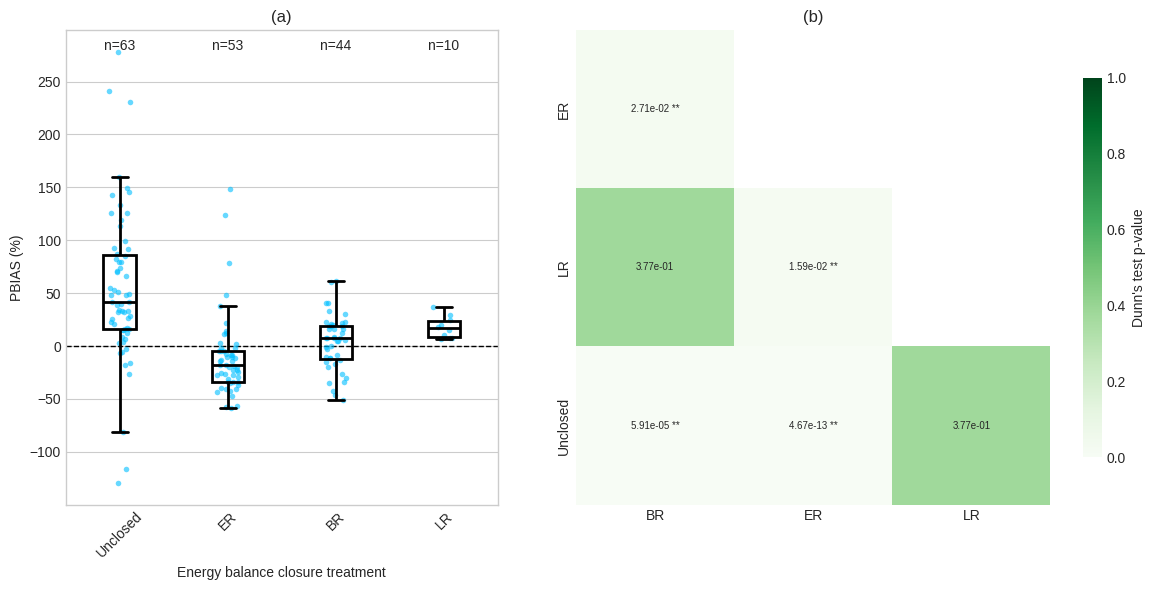

In [102]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [2, 3]})
df_ = df_EC

# Plot strip plot first (so it's underneath)
sns.stripplot(x='label', y='PBIAS (%)', ax=axes[0],data=df_,
              color='deepskyblue', jitter=True, size=4, alpha=0.6,order=model_labels)

# Overlay boxplot with no fill and thicker, brighter outline
sns.boxplot(
    x='label', y='PBIAS (%)', data=df_,ax=axes[0],
    width=0.3, showcaps=True, showfliers=False,
    boxprops=dict(facecolor='none', edgecolor='black', linewidth=2, zorder=3),
    whiskerprops=dict(color='black', linewidth=2, zorder=3),
    capprops=dict(color='black', linewidth=2, zorder=3),
    medianprops=dict(color='black', linewidth=2, zorder=3)
)

# Annotate group sizes
group_counts = df_['label'].value_counts().reset_index()
group_counts.columns = ['label', 'count']
# Ensure group_counts is in the same order as model_labels for correct annotation placement
group_counts = group_counts.set_index('label').loc[model_labels].reset_index()


for i, model_type in enumerate(model_labels):
    count = group_counts[group_counts['label'] == model_type]['count'].values[0]
    # Adjust text placement slightly if needed based on the log scale
    axes[0].text(i, df_['PBIAS (%)'].max() + 2, f'n={count}', ha='center')


# Labels and title
axes[0].axhline(y=0, color='black', linestyle='--', linewidth=1) # Corrected method here
axes[0].set_xlabel('Energy balance closure treatment')
axes[0].set_ylabel('PBIAS (%)') # Update y-axis label
# axes[0].set_yscale('symlog', linthresh=1) # Set y-axis to symmetric log scale to handle negative values
# axes[0].set_ylim(-1000,1000)
axes[0].set_title('(a)') # Add title for the first subplot
axes[0].tick_params(axis='x', rotation=45)

#------------------------------------------------------
# build an upper‐triangle mask
dunn_results = sp.posthoc_dunn(df_, val_col='PBIAS (%)', group_col='label', p_adjust='holm')
mask = np.triu(np.ones_like(dunn_results, dtype=bool))

# Create a custom colormap
# Red for p-values < 0.05, shades of green for others
cmap = sns.color_palette("Greens", as_cmap=True)
cmap.set_bad('white') # Set color for masked values

# Create annotations with asterisks for significant values and scientific format
annot_df = dunn_results.copy().astype(str)
for i in range(dunn_results.shape[0]):
    for j in range(dunn_results.shape[1]):
        if pd.notna(dunn_results.iloc[i, j]):
            if dunn_results.iloc[i, j] < 0.05:
                # Format significant p-values in scientific notation with asterisk
                annot_df.iloc[i, j] = f"{dunn_results.iloc[i, j]:.2e} **"
            else:
                # Format non-significant p-values in scientific notation
                annot_df.iloc[i, j] = f"{dunn_results.iloc[i, j]:.2e}"
        else:
            annot_df.iloc[i, j] = ""

# Slice the DataFrame to remove the first row and last column
dunn_results_sliced = dunn_results.iloc[1:, :-1]
annot_df_sliced = annot_df.iloc[1:, :-1]
mask_sliced = mask[1:, :-1]

sns.heatmap(
    dunn_results_sliced,
    mask=mask_sliced,
    annot=annot_df_sliced, # Use the custom annotated dataframe
    annot_kws={"fontsize": 7},
    cmap=cmap, # Use the custom colormap
    fmt="", # Use empty format as we are formatting in annot_df
    square=True,
    cbar_kws={"shrink": 0.8,  "label": "Dunn's test p-value"}, # Added orientation and label
    vmin=0, vmax=1, # Set value range for colormap
    ax=axes[1]
)
axes[1].set_title('(b)') # Add title for the second subplot
plt.tight_layout()
plt.savefig(os.path.join(save_folder,'5_pbias_by_EBC_treatments.png'), bbox_inches='tight')
plt.show()